# 🔬 Image Analysis: PadFISH Image Analysis
**Project**: 2025_HUVEC_ATAC_revisions  
**Date**: 2025-07-22
**Author**: Anne Rademacher 

---

### 🎯 Objective  
This notebook is used for analyzing microscopy images using Python. It includes image and mask loading and more. The use case is padFISH on HUVEC cells with intronic probes against CXCL8.
To run it, activate the micromamba environment (local) `micromamba activate microscopy-env` and start Jupyter lab with `jupyter lab`.

---

## 📦 Imports and setup

In [1]:
import pandas as pd
from pathlib import Path
import re
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from tifffile import imread
import colorcet as cc

from skimage.draw import rectangle
from scipy import ndimage as ndi

import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.stats import norm as stats_norm

import math

---

## 🔧 Utility Functions

#### Image display functions

---

In [2]:
def clip_and_rescale(image, clip_value, use_percentile=False):
    """
    Clip image intensities either at a fixed value or at a percentile, then rescale to [0, 1].

    Parameters:
        image (np.ndarray): Input image array (e.g. uint16).
        clip_value (float or int): Max intensity value or percentile to clip at.
        use_percentile (bool): If True, interpret clip_value as a percentile (0-100).
                               If False, clip_value is treated as fixed intensity threshold.

    Returns:
        tuple:
            - np.ndarray: Float array with intensities rescaled to [0, 1].
            - float: The actual clipping threshold used.
    """
    if use_percentile:
        threshold = np.percentile(image, clip_value)
    else:
        threshold = clip_value

    clipped = np.clip(image, 0, threshold)
    rescaled = clipped.astype(np.float32) / threshold

    return rescaled, threshold

In [3]:
def add_scalebar(image, px_size_nm=201, scalebar_size_um: int =10, pad_frac=0.02):
    """
    Adds a white scale bar to the bottom-right corner of a grayscale or RGB image.

    Parameters:
        image (np.ndarray): Input 2D or 3D image (values in [0, 1] or raw intensities).
        px_size_nm (float): Pixel size in nanometers.
        scalebar_size_um (float): Desired length of scale bar in microns.
        pad_frac (float): Fraction of image dimensions used for padding.

    Returns:
        img_with_bar (np.ndarray): Image with scale bar added.
        pad_x (int): Padding in x (pixels) from image edge.
        pad_y (int): Padding in y (pixels) from image edge.
        scalebar_length_px (int): Length of the scalebar in pixels.
    """
    # Copy image to avoid modifying original
    img_with_bar = image.copy()

    h, w = image.shape[:2]

    px_size_um = px_size_nm / 1000
    scalebar_length_px = int(scalebar_size_um / px_size_um)

    pad_x = int(pad_frac * w)
    pad_y = int(pad_frac * h)

    bar_height = max(2, h // 100)

    start_y = h - bar_height - pad_y
    start_x = w - scalebar_length_px - pad_x
    end_y = start_y + bar_height
    end_x = start_x + scalebar_length_px

    if img_with_bar.ndim == 2:
        rr, cc = rectangle(start=(start_y, start_x), end=(end_y, end_x), shape=image.shape)
        img_with_bar[rr, cc] = np.max(img_with_bar)
    elif img_with_bar.ndim == 3 and img_with_bar.shape[2] in [3, 4]:
        rr, cc = rectangle(start=(start_y, start_x), end=(end_y, end_x), shape=image.shape[:2])
        img_with_bar[rr, cc, :] = 1.0
    else:
        raise ValueError("Unsupported image shape for scale bar.")

    return img_with_bar, pad_x, pad_y, scalebar_length_px

In [4]:
def get_rgb_mask(mask_path):
    
    # Load mask image as numpy array
    mask = imread(mask_path)
    mask = np.nan_to_num(mask, nan=0).astype(int)

    # Extract labels excluding background (0)
    labels = np.unique(mask)
    labels = labels[labels != 0]

    # Prepare Glasbey colors (256 colors)
    glasbey_colors = cc.glasbey  # list of hex color strings

    # Repeat colors if needed
    repeats = int(np.ceil(len(labels) / len(glasbey_colors)))
    cycled_colors = (glasbey_colors * repeats)[:len(labels)]

    # Create LUT: max label + 1 rows, 3 cols (RGB)
    max_label = mask.max()
    lut = np.zeros((max_label + 1, 3), dtype=np.float32)
    lut[0] = [0, 0, 0]  # background color (black)

    # Map each label to RGB color
    for lbl, col in zip(labels, cycled_colors):
        lut[lbl] = mcolors.to_rgb(col)

    # Vectorized lookup: build RGB image
    rgb_mask = lut[mask]

    return rgb_mask

#### Image quantification functions

---

In [5]:
def measure_cells_fast(mask_path, fluor_path, replicate, timepoint):
    mask = imread(mask_path)
    mask = np.nan_to_num(mask, nan=0).astype(int)
    fluor = imread(fluor_path)

    fluor = np.nan_to_num(fluor, nan=0.0, posinf=0.0, neginf=0.0)

    # Get label histogram: counts of pixels per label
    labels, counts = np.unique(mask, return_counts=True)

    # Remove background and labels with no pixels
    label_valid = (labels != 0) & (counts > 0)
    labels = labels[label_valid]

    # Area (pixel count)
    area_px = ndi.sum(np.ones_like(fluor), labels=mask, index=labels)

    # Filter out labels with area <= 0 (paranoia filter)
    valid = area_px > 0
    labels = labels[valid]
    area_px = area_px[valid]

    # Now safely compute all stats
    intensity_mean = ndi.mean(fluor, labels=mask, index=labels)
    intensity_std = ndi.standard_deviation(fluor, labels=mask, index=labels)
    integrated_intensity = intensity_mean * area_px

    medians = compute_median_intensity_fast(mask, fluor)
    intensity_median = [medians.get(cell_id, np.nan) for cell_id in labels]

    # Final DataFrame
    df = pd.DataFrame({
        'cell_id': labels,
        'area_px': area_px,
        'intensity_mean': intensity_mean,
        'intensity_std': intensity_std,
        'intensity_median': intensity_median,
        'integrated_intensity': integrated_intensity,
        'replicate': replicate,
        'timepoint': timepoint
    })

    return df


In [6]:
def compute_median_intensity_fast(mask, fluor):
    """
    Faster version of computing median intensity per label using vectorized Pandas groupby.
    """
    flat_mask = mask.ravel()
    flat_fluor = fluor.ravel()

    valid = flat_mask > 0
    df_pix = pd.DataFrame({
        'label': flat_mask[valid],
        'intensity': flat_fluor[valid]
    })

    # Group by label and get median
    medians = df_pix.groupby('label')['intensity'].median()

    return medians.to_dict()  # Optional: return as dict for mapping


#### Normalization helper function

---

In [7]:
def normalize_to_baseline(df, value_col, group_col='replicate', baseline_tp='0h'):
    """
    Normalize values in value_col by the baseline_tp within each group_col.
    """
    baseline_df = df[df['timepoint'] == baseline_tp]
    missing_reps = set(df[group_col]) - set(baseline_df[group_col])
    if missing_reps:
        raise RuntimeError(f"No baseline ({baseline_tp}) for replicates: {sorted(missing_reps)}")

    baseline = (
        baseline_df
        .set_index(group_col)[value_col]
        .to_dict()
    )

    df[f'{value_col}_fc'] = df.apply(
        lambda row: row[value_col] / baseline[row[group_col]],
        axis=1
    )

    df[f'{value_col}_log2fc'] = np.log2(df[f'{value_col}_fc'])

    return df

## 📂 Step 1: Organize the relevant files and metadata

---

In [8]:
# 1. Set root path (folder containing subfolders per replicate, e. g. 20251007_rep4)
root = Path("/Volumes/sd17B002/Microscopy-Dragonfly/AR_SpatialTranscriptomics/2025_HUVEC_ATAC_revisions/BurstAnalysis/ImageAnalysis/CXCL8")

# 2. List all files recursively
all_files = list(root.rglob('*'))  # list all files/folders recursively

# 3. Filter only relevant files by suffix or pattern
pattern = re.compile(r"(_final\.tiff$|Sum_IntegrInt_table\.csv$|Fused_637nm_corr\.tif$)")

relevant_files = [f for f in all_files if not f.name.startswith('._') and
                  re.search(r'_final\.tiff$|Sum_IntegrInt_table\.csv$|Fused_637nm_corr\.tif$', str(f))]

# 4. Extract metadata for each file
data = []
for f in relevant_files:
    path_str = str(f)
    replicate = f.parent.name  # folder containing the file
    
    # Extract timepoint using regex (look for 0h, 30min, or 240min between underscores)
    # capture 0h *or* 0min, as well as 30min / 240min
    timepoint_match = re.search(r'_(0h|0min|30min|240min)_', path_str)
    timepoint = timepoint_match.group(1) if timepoint_match else None

    # Normalize '0min' to '0h' so ordering & grouping stay consistent
    if timepoint == '0min':
        timepoint = '0h'
        
    # Determine type based on filename pattern
    if re.search(r'_final\.tiff$', path_str):
        file_type = 'mask'
    elif re.search(r'Sum_IntegrInt_table\.csv$', path_str):     # csvs not used in this analysis
        file_type = 'csv'
    elif re.search(r'Fused_637nm_corr\.tif$', path_str):
        file_type = 'fluor'
    else:
        file_type = None
    
    data.append({'path': path_str, 'replicate': replicate, 'timepoint': timepoint, 'type': file_type})

# 5. Create a DataFrame
files_df = pd.DataFrame(data)

# 6. Pivot to wide format for easy joining later
files_wide = files_df.pivot_table(index=['replicate', 'timepoint'], columns='type', values='path', aggfunc='first').reset_index()

# 7. Reorder rows

# Define the desired order for timepoints
timepoint_order = ['0h', '30min', '240min']

# Convert the 'timepoint' column to a categorical with the defined order
files_wide['timepoint'] = pd.Categorical(files_wide['timepoint'], categories=timepoint_order, ordered=True)

# Now sort by 'replicate' and then by this ordered 'timepoint'
files_wide = files_wide.sort_values(by=['replicate', 'timepoint']).reset_index(drop=True)

# 8. Peek at structure
print(files_df.head())
#print(files_wide)


                                                path      replicate timepoint  \
0  /Volumes/sd17B002/Microscopy-Dragonfly/AR_Spat...  20250124_Rep4        0h   
1  /Volumes/sd17B002/Microscopy-Dragonfly/AR_Spat...  20250124_Rep4     30min   
2  /Volumes/sd17B002/Microscopy-Dragonfly/AR_Spat...  20250124_Rep4        0h   
3  /Volumes/sd17B002/Microscopy-Dragonfly/AR_Spat...  20250124_Rep4     30min   
4  /Volumes/sd17B002/Microscopy-Dragonfly/AR_Spat...  20250124_Rep4    240min   

    type  
0  fluor  
1  fluor  
2   mask  
3   mask  
4   mask  


## 📂 Step 2: Inspect masks and images

---

This is an optional check to take a peak at the image and corresponding mask image to make sure that the images are correctly loaded. It is also helpful for a quick check for large artifacts or missegmentations.

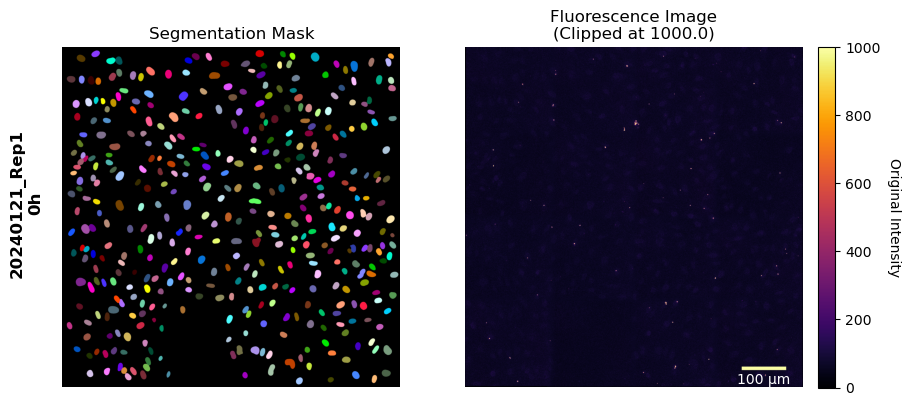

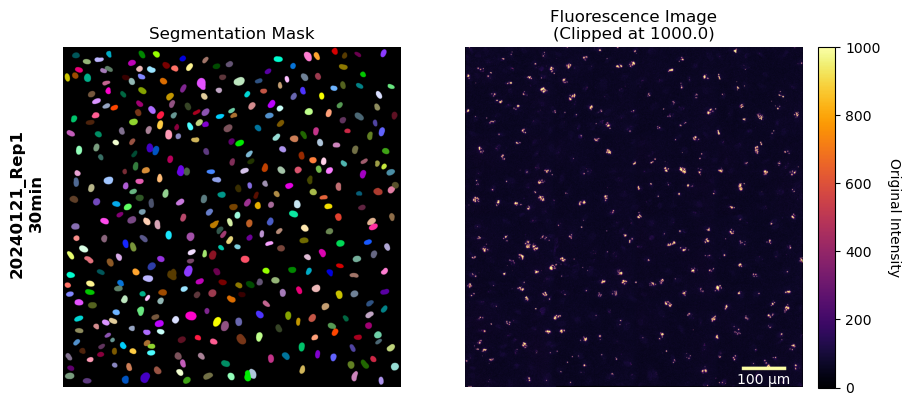

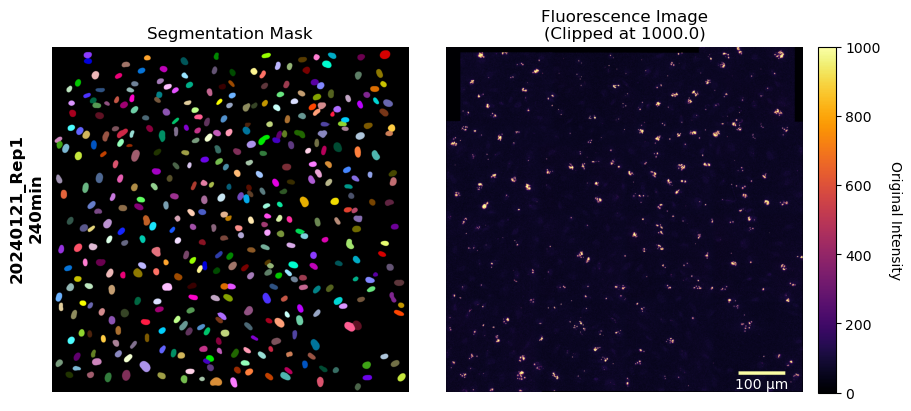

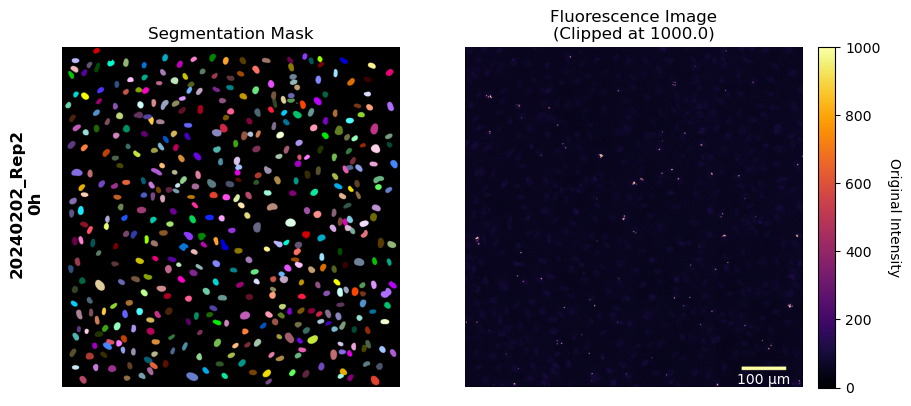

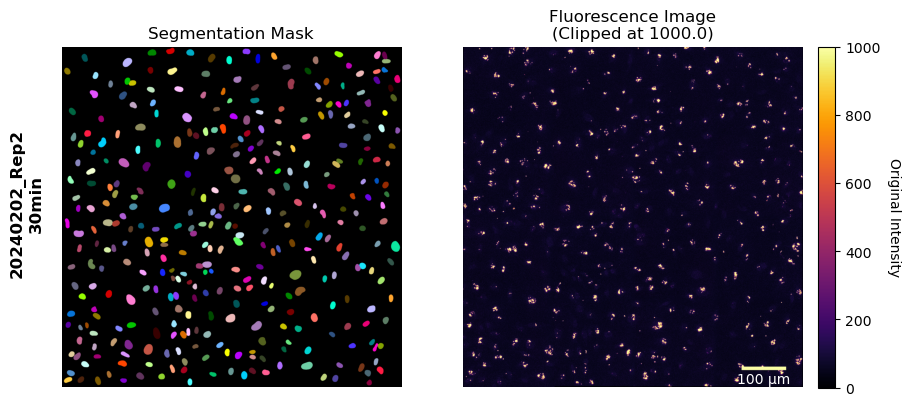

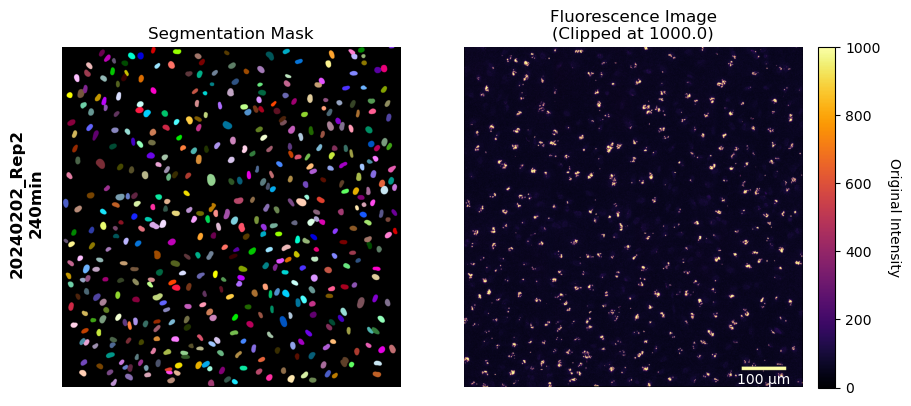

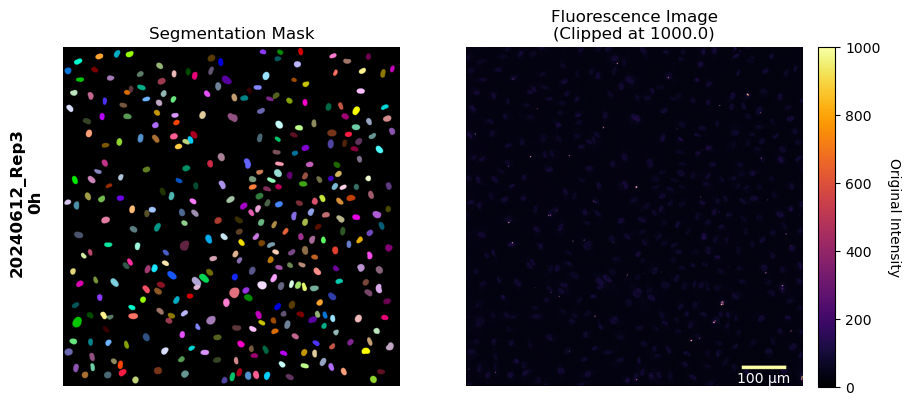

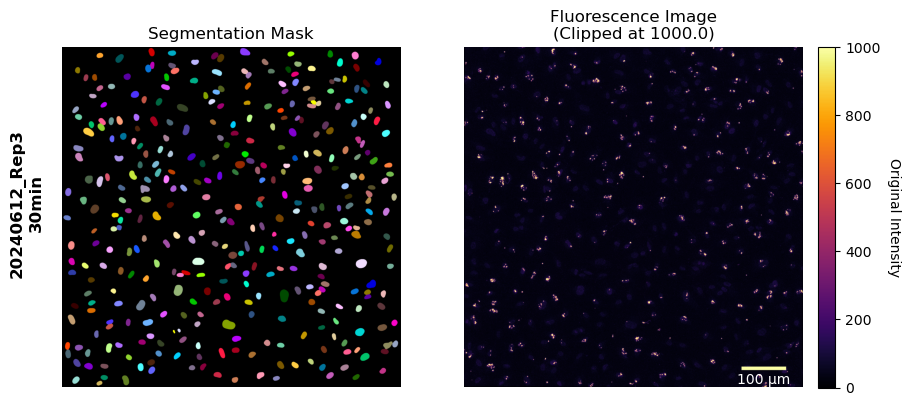

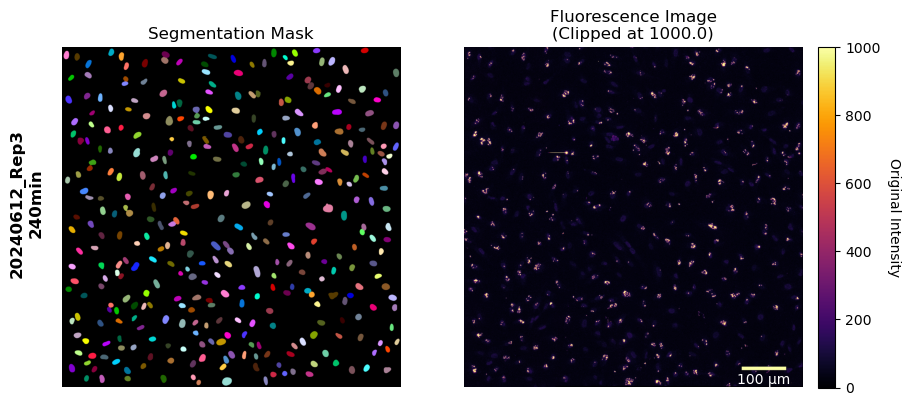

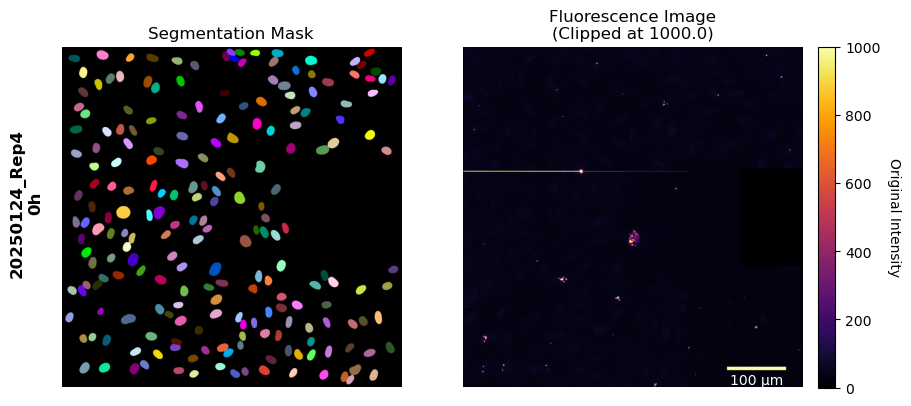

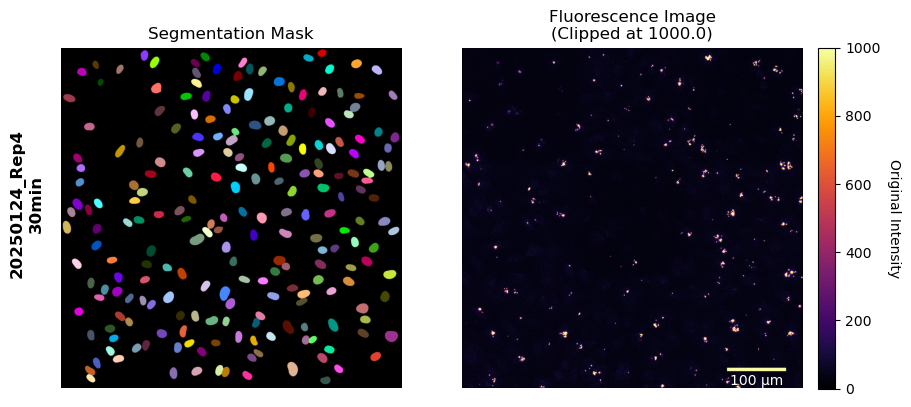

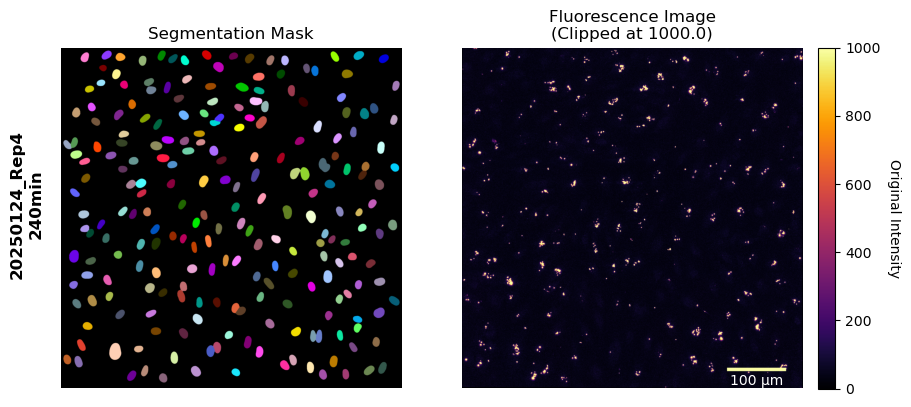

In [9]:
for idx, row in files_wide.iterrows():
    # Extract info
    fluor_path = row['fluor']
    mask_path = row['mask']
    replicate = row['replicate']
    timepoint = row['timepoint']

    # Load mask as RGB
    rgb_mask = get_rgb_mask(mask_path)

    # Load and rescale fluorescence image
    fluor = imread(fluor_path)
    rescaled_img, clip_used = clip_and_rescale(fluor, clip_value=1000, use_percentile=False)

    # Add scale bar to image and get bar info
    fluor_with_bar, pad_x, pad_y, scalebar_length_px = add_scalebar(
        rescaled_img, 
        px_size_nm=201, 
        scalebar_size_um=100, 
        pad_frac=0.05
    )
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    
    # Mask plot
    axs[0].imshow(rgb_mask)
    axs[0].axis('off')
    axs[0].set_title("Segmentation Mask")
    
    # Fluorescence with scale bar
    im = axs[1].imshow(fluor_with_bar, cmap='inferno', vmin=0, vmax=1)
    axs[1].axis('off')
    axs[1].set_title(f"Fluorescence Image\n(Clipped at {clip_used:.1f})")
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    ticks = np.linspace(0, 1, 6)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t * clip_used:.0f}" for t in ticks])
    cbar.set_label('Original Intensity', rotation=270, labelpad=15)

    # Add scale bar label below the bar
    h, w = fluor_with_bar.shape[:2]
    label_x = w - pad_x - scalebar_length_px / 2
    label_y = h - pad_y + 20  # 20 pixels below bar
    axs[1].text(label_x, label_y, f"{100} µm", color='white', fontsize=10, ha='center', va='top')
    
    # Vertical label with replicate + timepoint
    fig.text(0.01, 0.5, f"{replicate}\n{timepoint}", va='center', ha='center',
             rotation='vertical', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()


## 🧬 Step 3: Nuclear intensity measurements

Calculate signal per nucleus, i. e. 
- size (number of pixels per mask)
- mean intensity
- integrated intensity
- standard deviation
- median intensity
---

### 3.1 Cell area distribution (raw data)


In [10]:
%%time
# Create empty list to collect DataFrames
all_measurements = []

for idx, row in files_wide.iterrows():
    replicate = row['replicate']
    timepoint = row['timepoint']
    mask_path = row['mask']
    fluor_path = row['fluor']

    df = measure_cells_fast(mask_path, fluor_path, replicate, timepoint)
    all_measurements.append(df)

# Concatenate all into a single DataFrame
measurements_df = pd.concat(all_measurements, ignore_index=True)

# Inspect the result
print(measurements_df.head())


/Users/anne/micromamba/envs/microscopy-env/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:646: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


   cell_id  area_px  intensity_mean  intensity_std  intensity_median  \
0        1   5859.0      104.146441     248.754200              85.0   
1        2   5213.0       71.896796      25.456886              69.0   
2        3   3545.0       79.387870      28.847978              76.0   
3        4   7573.0       78.919451      29.144995              76.0   
4        5   3867.0       78.976726      39.998261              74.0   

   integrated_intensity      replicate timepoint  
0              610194.0  20240121_Rep1        0h  
1              374798.0  20240121_Rep1        0h  
2              281430.0  20240121_Rep1        0h  
3              597657.0  20240121_Rep1        0h  
4              305403.0  20240121_Rep1        0h  
CPU times: user 6.64 s, sys: 1.22 s, total: 7.85 s
Wall time: 7.88 s


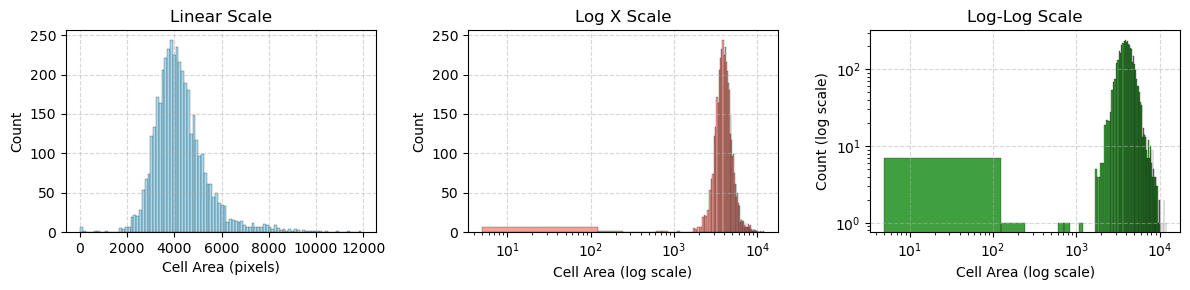

In [11]:
area_values = measurements_df['area_px'].dropna()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

# --- Plot 1: Linear scale ---
sns.histplot(area_values, bins=100, kde=False, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_xlabel("Cell Area (pixels)")
axes[0].set_ylabel("Count")
axes[0].set_title("Linear Scale")
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- Plot 2: Log x-scale ---
sns.histplot(area_values, bins=100, kde=False, color='salmon', edgecolor='black', ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_xlabel("Cell Area (log scale)")
axes[1].set_ylabel("Count")
axes[1].set_title("Log X Scale")
axes[1].grid(True, linestyle='--', alpha=0.5)

# --- Plot 3: Log x and y scales ---
sns.histplot(area_values, bins=100, kde=False, color='green', edgecolor='black', ax=axes[2])
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Cell Area (log scale)")
axes[2].set_ylabel("Count (log scale)")
axes[2].set_title("Log-Log Scale")
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### 3.2 Cell Area Filtering


In [12]:
df = measurements_df.copy()

# Filter out any zeros or negatives before log-transforming integrated intensity and median intensity
df = df[(df['integrated_intensity'] > 0) & (df['intensity_median'] > 0) & (df['intensity_mean'] > 0) & (df['area_px'] > 0)].copy()

# Count how many rows have area < 500
num_removed = (df['area_px'] < 500).sum()
total_cells = len(df)
print(f"Removed {num_removed} cells with area < 500 px ({num_removed/total_cells:.2%} of total)")

# Filter out small objects
df = df[df['area_px'] >= 500].copy()

# Add log10 versions
df['log10_intensity'] = np.log10(df['integrated_intensity'])
df['log10_median_intensity'] = np.log10(df['intensity_median'])
df['log10_mean_intensity'] = np.log10(df['intensity_mean'])
df['log10_std_intensity'] = np.log10(df['intensity_std'])

# Calculate coefficient of variation (CV)
df['cv_intensity'] = df['intensity_std'] / df['intensity_mean']
df['log10_cv_intensity'] = np.log10(df['cv_intensity'])

df.head()

Removed 8 cells with area < 500 px (0.19% of total)


cell_id  area_px  intensity_mean  intensity_std  intensity_median  \
0        1   5859.0      104.146441     248.754200              85.0   
1        2   5213.0       71.896796      25.456886              69.0   
2        3   3545.0       79.387870      28.847978              76.0   
3        4   7573.0       78.919451      29.144995              76.0   
4        5   3867.0       78.976726      39.998261              74.0   

   integrated_intensity      replicate timepoint  log10_intensity  \
0              610194.0  20240121_Rep1        0h         5.785468   
1              374798.0  20240121_Rep1        0h         5.573797   
2              281430.0  20240121_Rep1        0h         5.449370   
3              597657.0  20240121_Rep1        0h         5.776452   
4              305403.0  20240121_Rep1        0h         5.484873   

   log10_median_intensity  log10_mean_intensity  log10_std_intensity  \
0                1.929419              2.017644             2.395770   
1                1.838849              1.856710             1.405805   
2                1.880814              1.899754             1.460115   
3                1.880814              1.897184             1.464564   
4                1.869232              1.897499             1.602041   

   cv_intensity  log10_cv_intensity  
0      2.388504            0.378126  
1      0.354075           -0.450904  
2      0.363380           -0.439639  
3      0.369301           -0.432620  
4      0.506456           -0.295458

### 3.3 Distribution Plots

---
#### Nuclear Area

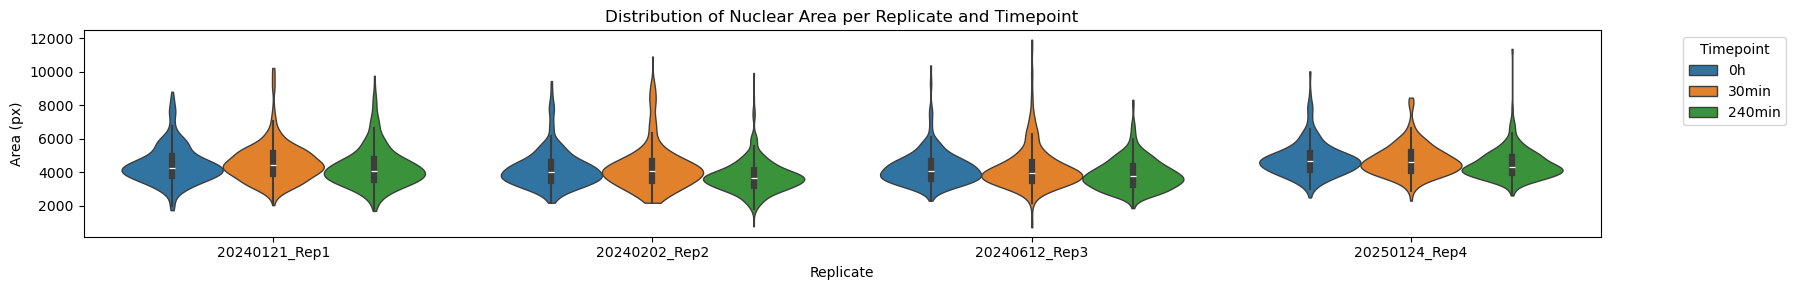

In [13]:
plt.figure(figsize=(18, 3))

# Violin with box inside
sns.violinplot(
    data=df,
    x="replicate",
    y="area_px",
    hue="timepoint",
    inner="box",           # Show boxplot inside
    density_norm='width',         # Same width for each violin (optional)
    dodge=True,            # Side-by-side grouping by hue
    cut=0,                 # Trim violins to actual data range
    linewidth=1            # Thinner outlines
)

# Tidy up the plot
plt.title("Distribution of Nuclear Area per Replicate and Timepoint")
plt.xlabel("Replicate")
plt.ylabel("Area (px)")
plt.legend(title="Timepoint", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside
plt.tight_layout()

---
#### Integrated Intensity


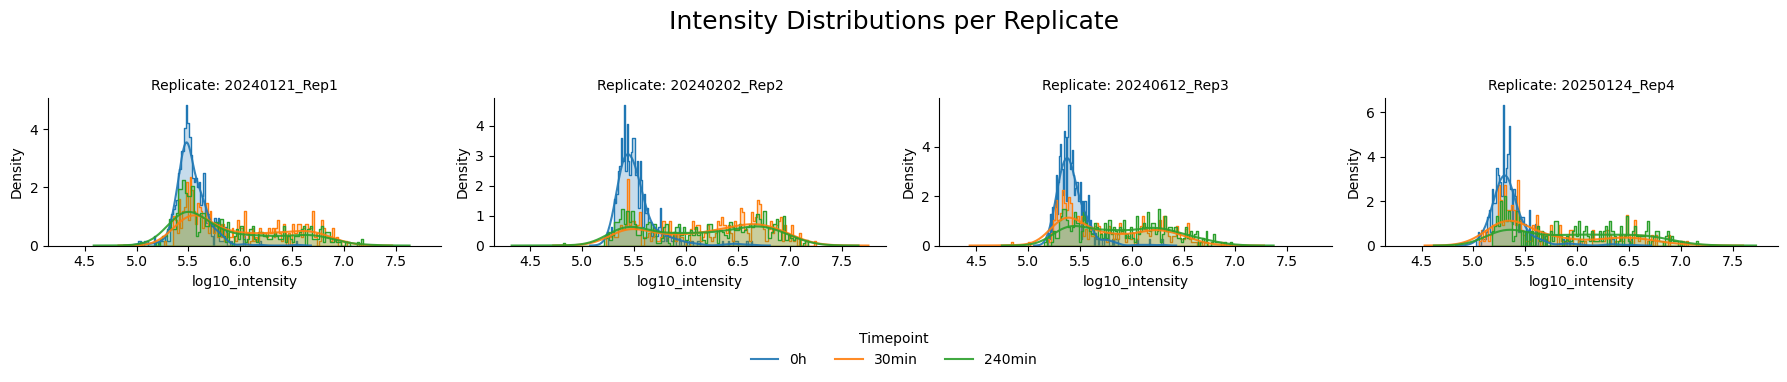

In [14]:
g = sns.FacetGrid(
    df,
    col="replicate",
    hue="timepoint",
    sharey=False,
    height=3,
    aspect=1.5
)

g.map(
    sns.histplot,
    "log10_intensity",
    stat="density",
    bins=100,
    element="step",
    fill=True,
    alpha=0.25,
    common_norm=False
)

g.map(
    sns.kdeplot,
    "log10_intensity",
    lw=1.5,
    alpha=0.9
)

# Titles, sizing, legend
g.set_titles(col_template="Replicate: {col_name}")
g.fig.set_size_inches(15, 3)  # Adjust width for 3 facets
g.add_legend(title="Timepoint", loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=5)

g.fig.suptitle("Intensity Distributions per Replicate", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.93])


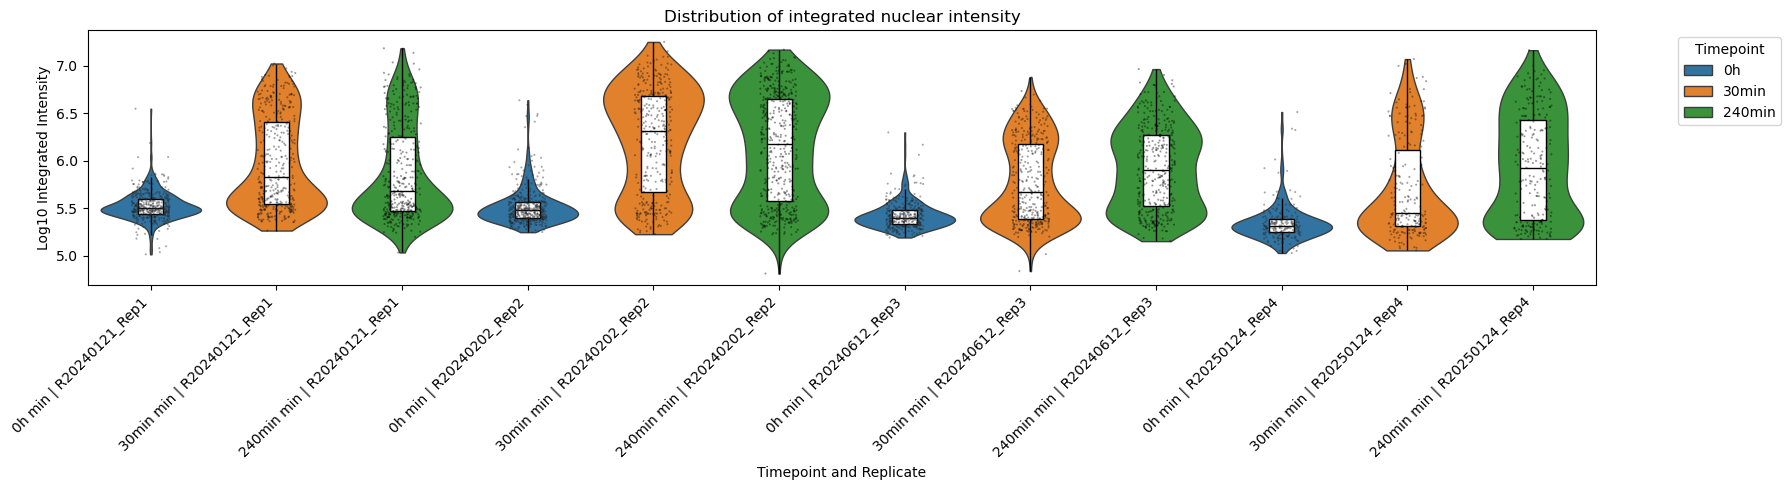

In [15]:
# Ensure x-label is clean
df['time_rep'] = df['timepoint'].astype(str) + " min | R" + df['replicate'].astype(str)

plt.figure(figsize=(18, 5))

# Violin plot (trimmed to data range)
sns.violinplot(
    data=df,
    x="time_rep",
    y="log10_intensity",
    hue="timepoint",
    palette="tab10",
    inner=None,          # No internal summary — we'll overlay our own
    cut=0,               # Trim to actual data range
    linewidth=1,
    density_norm="width",
    dodge=False
)

# Boxplot overlay
sns.boxplot(
    data=df,
    x="time_rep",
    y="log10_intensity",
    hue="timepoint",
    palette="tab10",
    width=0.2,
    showcaps=False,
    capprops=dict(visible=False),
    whiskerprops=dict(color='black'),
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='black'),
    showfliers=False,
    linewidth=1,
    dodge=False
)

# Overlay individual points (for "outliers" or all points)
sns.stripplot(
    data=df,
    x="time_rep",
    y="log10_intensity",
    hue="timepoint",
    dodge=False,
    palette='dark:black',
    size=1.5,
    jitter=0.15,
    alpha=0.4
)

# Deduplicate legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
n_timepoints = df['timepoint'].nunique()
plt.legend(handles[:n_timepoints], labels[:n_timepoints], title="Timepoint", bbox_to_anchor=(1.05, 1), loc='upper left')

# Format
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Timepoint and Replicate")
plt.ylabel("Log10 Integrated Intensity")
plt.title("Distribution of integrated nuclear intensity")
plt.tight_layout()
plt.show()

---
#### Median Intensity

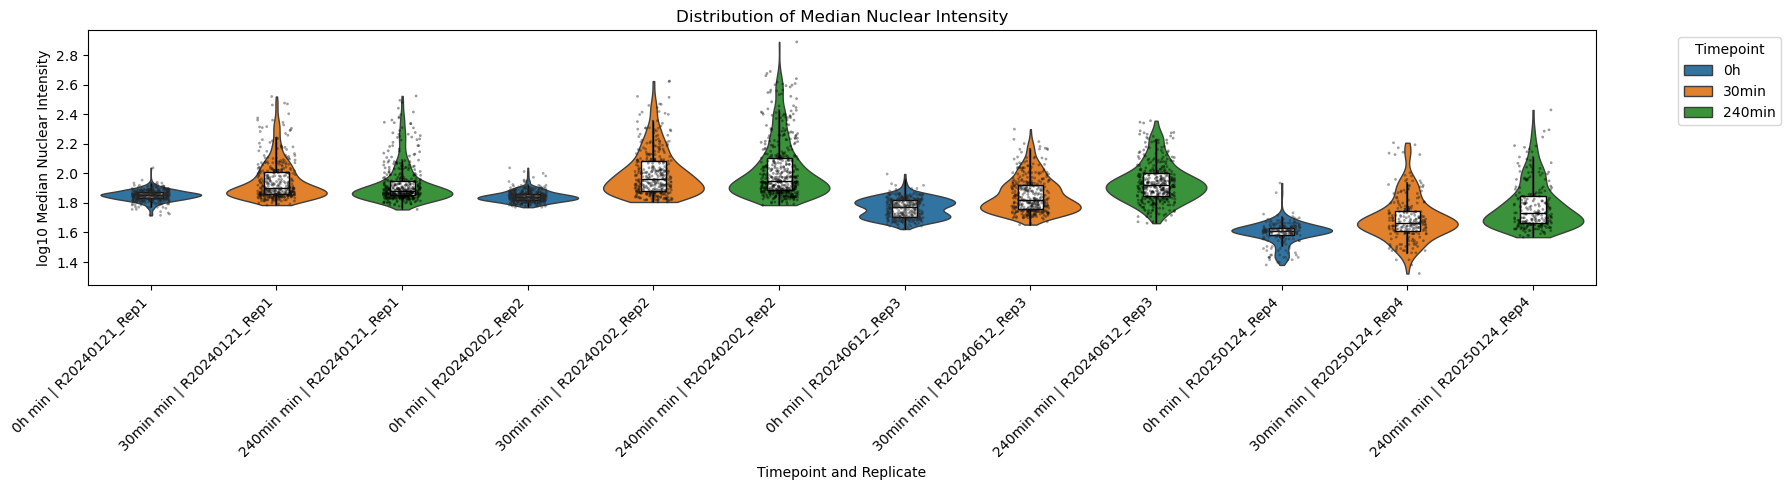

In [16]:
plt.figure(figsize=(18, 5))

# Violin plot with boxplot inside
sns.violinplot(
    data=df,
    x="time_rep",            # combined timepoint & replicate as before
    y="log10_median_intensity",    # swap y-axis to median intensity
    hue="timepoint",
    inner="box",             # boxplot inside violin
    dodge=False,
    linewidth=1,
    palette="tab10",
    density_norm='width',           # same width violins
    cut=0                    # no trimming, full range
)

sns.boxplot(
    data=df,
    x="time_rep",
    y="log10_median_intensity",
    hue="timepoint",
    palette="tab10",
    width=0.2,
    showcaps=False,
    capprops=dict(visible=False),
    whiskerprops=dict(color='black'),
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='black'),
    showfliers=False,
    linewidth=1,
    dodge=False
)

# Add outliers as dots
sns.stripplot(
    data=df,
    x="time_rep",
    y="log10_median_intensity",
    hue="timepoint",
    dodge=False,
    palette='dark:black',
    size=2,
    jitter=0.15,
    alpha=0.4
)

# Fix legend: keep only one set of hue entries
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
n_timepoints = df['timepoint'].nunique()
plt.legend(handles[:n_timepoints], labels[:n_timepoints], title="Timepoint", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Timepoint and Replicate")
plt.ylabel("log10 Median Nuclear Intensity")
plt.title("Distribution of Median Nuclear Intensity")
plt.tight_layout()
plt.show()


---
#### Mean Intensity

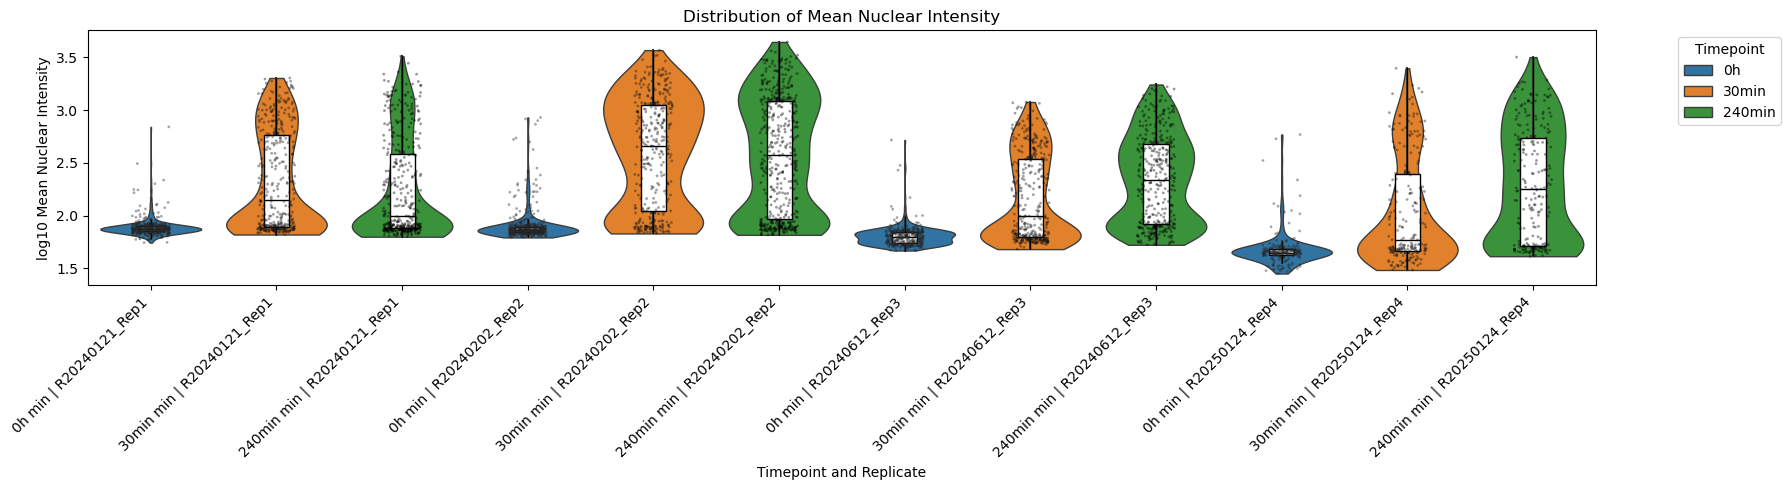

In [17]:
plt.figure(figsize=(18, 5))

# Violin plot with boxplot inside
sns.violinplot(
    data=df,
    x="time_rep",            # combined timepoint & replicate as before
    y="log10_mean_intensity",    # swap y-axis to median intensity
    hue="timepoint",
    inner="box",             # boxplot inside violin
    dodge=False,
    linewidth=1,
    palette="tab10",
    density_norm='width',           # same width violins
    cut=0                    # no trimming, full range
)

sns.boxplot(
    data=df,
    x="time_rep",
    y="log10_mean_intensity",
    hue="timepoint",
    palette="tab10",
    width=0.2,
    showcaps=False,
    capprops=dict(visible=False),
    whiskerprops=dict(color='black'),
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='black'),
    showfliers=False,
    linewidth=1,
    dodge=False
)

# Add outliers as dots
sns.stripplot(
    data=df,
    x="time_rep",
    y="log10_mean_intensity",
    hue="timepoint",
    dodge=False,
    palette='dark:black',
    size=2,
    jitter=0.15,
    alpha=0.4
)

# Fix legend: keep only one set of hue entries
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
n_timepoints = df['timepoint'].nunique()
plt.legend(handles[:n_timepoints], labels[:n_timepoints], title="Timepoint", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Timepoint and Replicate")
plt.ylabel("log10 Mean Nuclear Intensity")
plt.title("Distribution of Mean Nuclear Intensity")
plt.tight_layout()
plt.show()


---
#### Standard deviation

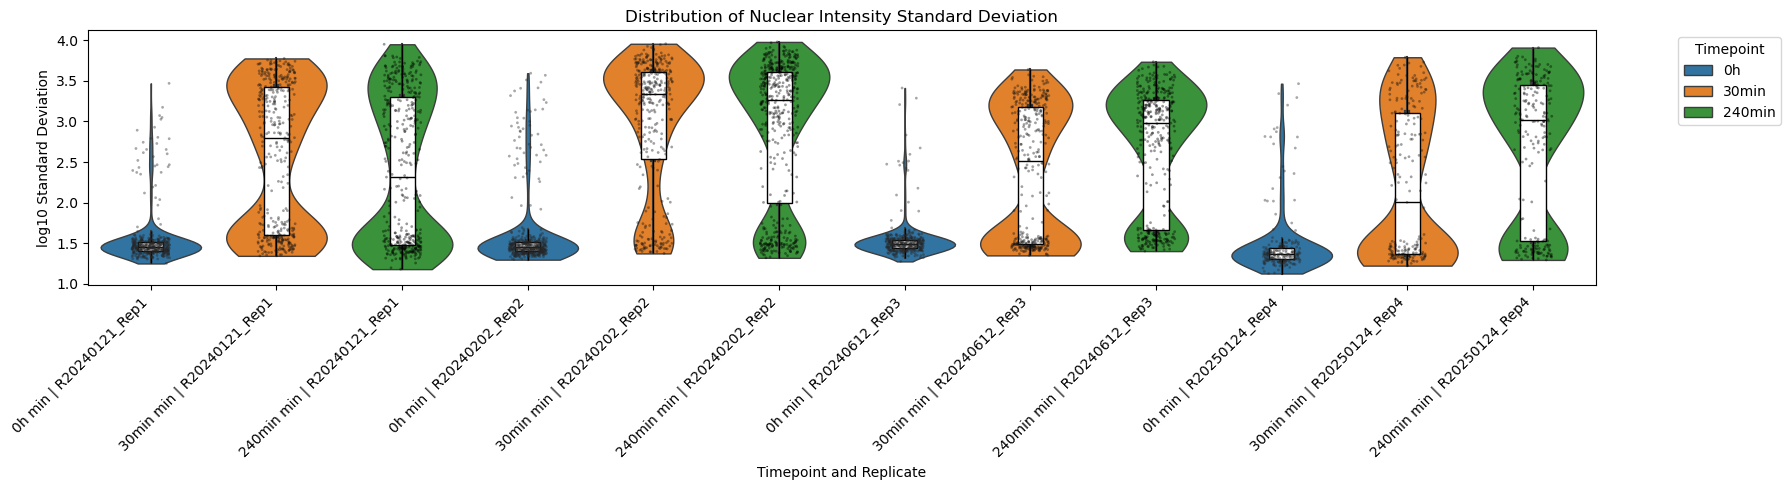

In [18]:
plt.figure(figsize=(18, 5))

# Violin plot with boxplot inside
sns.violinplot(
    data=df,
    x="time_rep",            # combined timepoint & replicate as before
    y="log10_std_intensity",    # swap y-axis to median intensity
    hue="timepoint",
    inner="box",             # boxplot inside violin
    dodge=False,
    linewidth=1,
    palette="tab10",
    density_norm='width',           # same width violins
    cut=0                    # no trimming, full range
)

sns.boxplot(
    data=df,
    x="time_rep",
    y="log10_std_intensity",
    hue="timepoint",
    palette="tab10",
    width=0.2,
    showcaps=False,
    capprops=dict(visible=False),
    whiskerprops=dict(color='black'),
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='black'),
    showfliers=False,
    linewidth=1,
    dodge=False
)

# Add outliers as dots
sns.stripplot(
    data=df,
    x="time_rep",
    y="log10_std_intensity",
    hue="timepoint",
    dodge=False,
    palette='dark:black',
    size=2,
    jitter=0.15,
    alpha=0.4
)

# Fix legend: keep only one set of hue entries
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
n_timepoints = df['timepoint'].nunique()
plt.legend(handles[:n_timepoints], labels[:n_timepoints], title="Timepoint", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Timepoint and Replicate")
plt.ylabel("log10 Standard Deviation")
plt.title("Distribution of Nuclear Intensity Standard Deviation")
plt.tight_layout()
plt.show()


---
#### Coefficient of variation

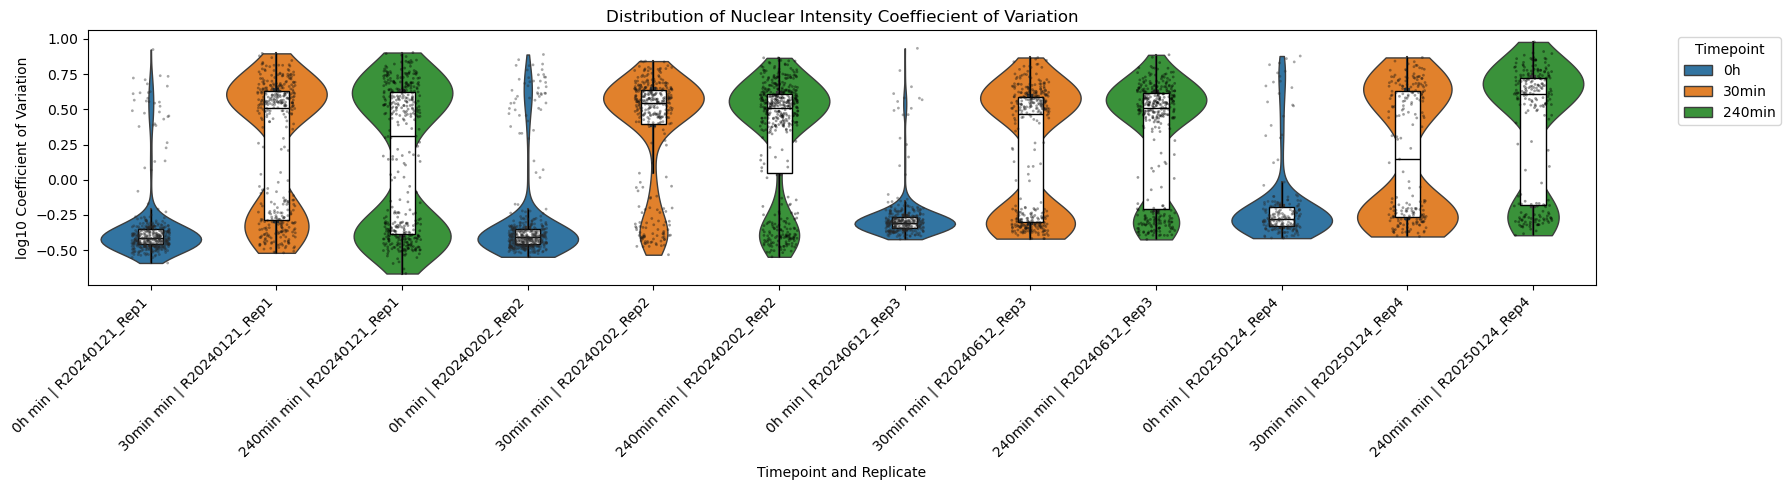

In [19]:
plt.figure(figsize=(18, 5))

# Violin plot with boxplot inside
sns.violinplot(
    data=df,
    x="time_rep",            # combined timepoint & replicate as before
    y="log10_cv_intensity",    # swap y-axis to median intensity
    hue="timepoint",
    inner="box",             # boxplot inside violin
    dodge=False,
    linewidth=1,
    palette="tab10",
    density_norm='width',           # same width violins
    cut=0                    # no trimming, full range
)

sns.boxplot(
    data=df,
    x="time_rep",
    y="log10_cv_intensity",
    hue="timepoint",
    palette="tab10",
    width=0.2,
    showcaps=False,
    capprops=dict(visible=False),
    whiskerprops=dict(color='black'),
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='black'),
    showfliers=False,
    linewidth=1,
    dodge=False
)

# Add outliers as dots
sns.stripplot(
    data=df,
    x="time_rep",
    y="log10_cv_intensity",
    hue="timepoint",
    dodge=False,
    palette='dark:black',
    size=2,
    jitter=0.15,
    alpha=0.4
)

# Fix legend: keep only one set of hue entries
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
n_timepoints = df['timepoint'].nunique()
plt.legend(handles[:n_timepoints], labels[:n_timepoints], title="Timepoint", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Timepoint and Replicate")
plt.ylabel("log10 Coefficient of Variation")
plt.title("Distribution of Nuclear Intensity Coeffiecient of Variation")
plt.tight_layout()
plt.show()


In [20]:
df.head()

cell_id  area_px  intensity_mean  intensity_std  intensity_median  \
0        1   5859.0      104.146441     248.754200              85.0   
1        2   5213.0       71.896796      25.456886              69.0   
2        3   3545.0       79.387870      28.847978              76.0   
3        4   7573.0       78.919451      29.144995              76.0   
4        5   3867.0       78.976726      39.998261              74.0   

   integrated_intensity      replicate timepoint  log10_intensity  \
0              610194.0  20240121_Rep1        0h         5.785468   
1              374798.0  20240121_Rep1        0h         5.573797   
2              281430.0  20240121_Rep1        0h         5.449370   
3              597657.0  20240121_Rep1        0h         5.776452   
4              305403.0  20240121_Rep1        0h         5.484873   

   log10_median_intensity  log10_mean_intensity  log10_std_intensity  \
0                1.929419              2.017644             2.395770   
1                1.838849              1.856710             1.405805   
2                1.880814              1.899754             1.460115   
3                1.880814              1.897184             1.464564   
4                1.869232              1.897499             1.602041   

   cv_intensity  log10_cv_intensity                 time_rep  
0      2.388504            0.378126  0h min | R20240121_Rep1  
1      0.354075           -0.450904  0h min | R20240121_Rep1  
2      0.363380           -0.439639  0h min | R20240121_Rep1  
3      0.369301           -0.432620  0h min | R20240121_Rep1  
4      0.506456           -0.295458  0h min | R20240121_Rep1

---
#### Combinations of measures in scatter plots

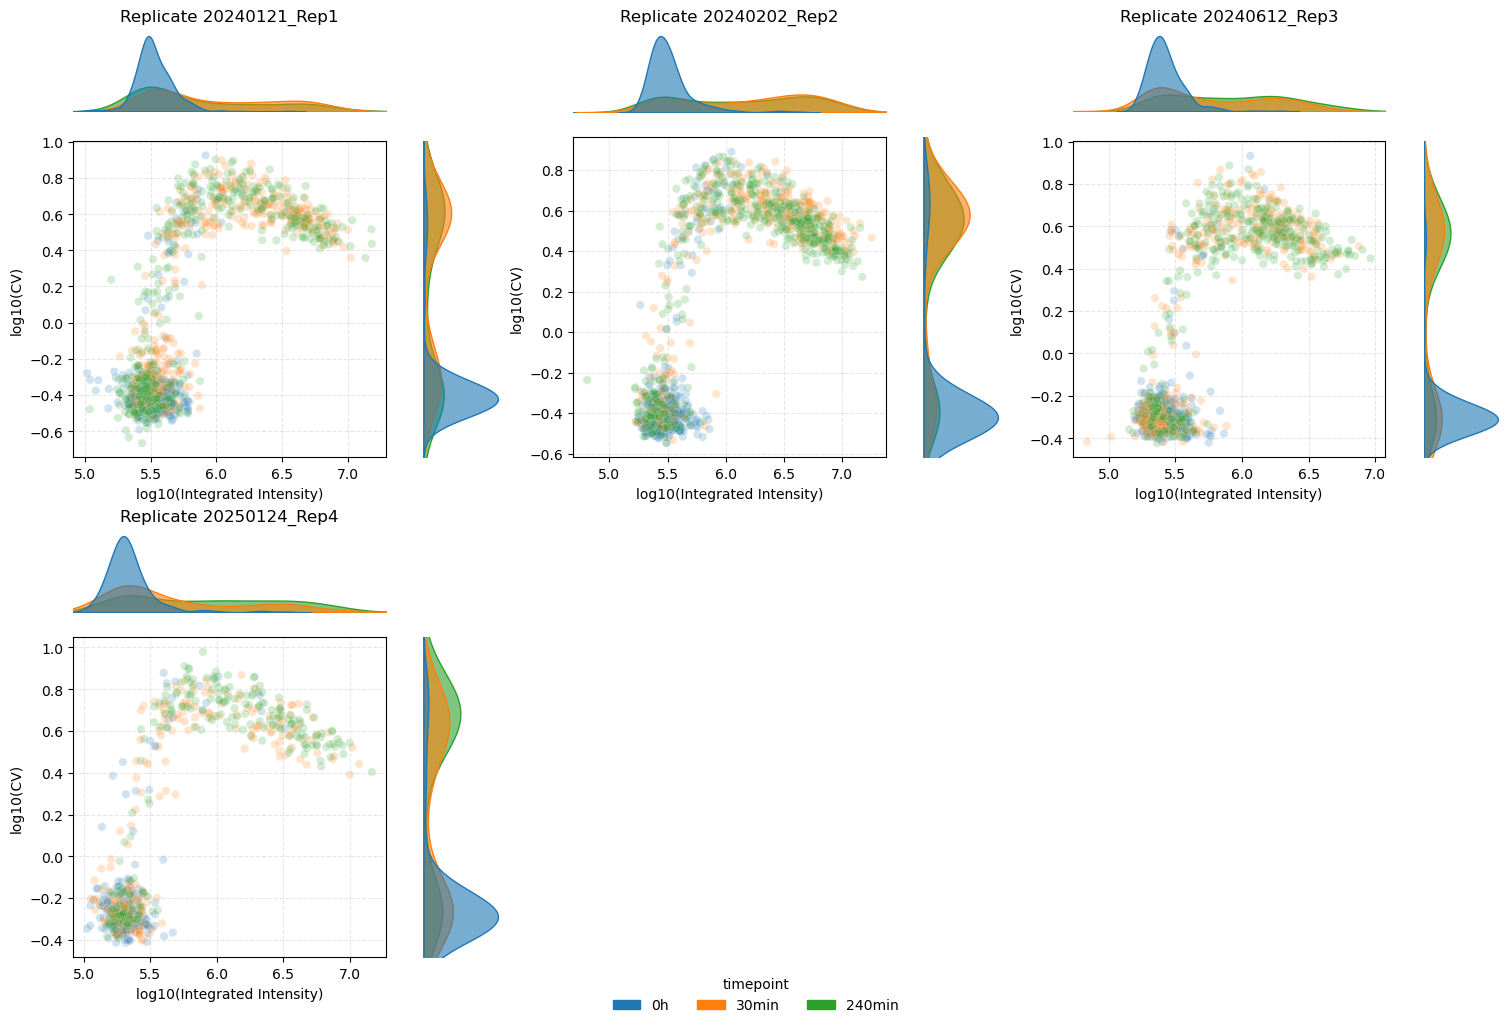

In [21]:
# --- config ---
xcol = 'log10_intensity'
ycol = 'log10_cv_intensity'
hue = 'timepoint'
max_cols = 3

tp_order = ["0h", "30min", "240min"]
df[hue] = pd.Categorical(df[hue], categories=tp_order, ordered=True)

hue_order = tp_order
palette = sns.color_palette(n_colors=len(hue_order))
palette_dict = dict(zip(hue_order, palette))

replicates = list(df['replicate'].unique())
n = len(replicates)
cols = min(max_cols, n)
rows = math.ceil(n / cols)

# Use constrained layout instead of tight_layout to avoid warnings
fig = plt.figure(figsize=(5 * cols, 5 * rows), constrained_layout=True)
outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.35, hspace=0.6)

for i, rep in enumerate(replicates):
    r, c = divmod(i, cols)
    inner = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec=outer[r, c],
        width_ratios=[4, 1], height_ratios=[1, 4],
        wspace=0.05, hspace=0.05
    )

    ax_top   = fig.add_subplot(inner[0, 0])
    ax_right = fig.add_subplot(inner[1, 1])
    ax_main  = fig.add_subplot(inner[1, 0])

    subset = df[df['replicate'] == rep]

    # --- main scatter ---
    sns.scatterplot(
        data=subset, x=xcol, y=ycol, hue=hue, hue_order=hue_order, palette=palette,
        alpha=0.2, ax=ax_main, legend=False
    )
    ax_main.set_xlabel("log10(Integrated Intensity)")
    ax_main.set_ylabel("log10(CV)")
    ax_main.grid(True, linestyle='--', alpha=0.3)

    # --- title ABOVE the mini-panel (attach to top marginal axis) ---
    ax_top.set_title(f"Replicate {rep}", pad=8)

    # --- top marginal KDE (x) ---
    sns.kdeplot(
        data=subset, x=xcol, hue=hue, hue_order=hue_order, palette=palette,
        ax=ax_top, fill=True, common_norm=False, legend=False, alpha=0.6
    )
    ax_top.set_xlabel("")
    ax_top.set_ylabel("")
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    for spine in ["right", "top", "left", "bottom"]:
        ax_top.spines[spine].set_visible(False)

    # --- right marginal KDE (y) ---
    sns.kdeplot(
        data=subset, y=ycol, hue=hue, hue_order=hue_order, palette=palette,
        ax=ax_right, fill=True, common_norm=False, legend=False, alpha=0.6
    )
    ax_right.set_xlabel("")
    ax_right.set_ylabel("")
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    for spine in ["right", "top", "left", "bottom"]:
        ax_right.spines[spine].set_visible(False)

    # Align marginals with main axes limits
    ax_top.set_xlim(ax_main.get_xlim())
    ax_right.set_ylim(ax_main.get_ylim())

# --- shared legend (placed below the grid) ---
handles = [patches.Patch(color=palette[i], label=str(lbl)) for i, lbl in enumerate(hue_order)]
fig.legend(
    handles, hue_order, title=hue,
    loc='lower center', bbox_to_anchor=(0.5, -0.02),
    ncol=min(4, len(hue_order)), frameon=False
)

plt.show()


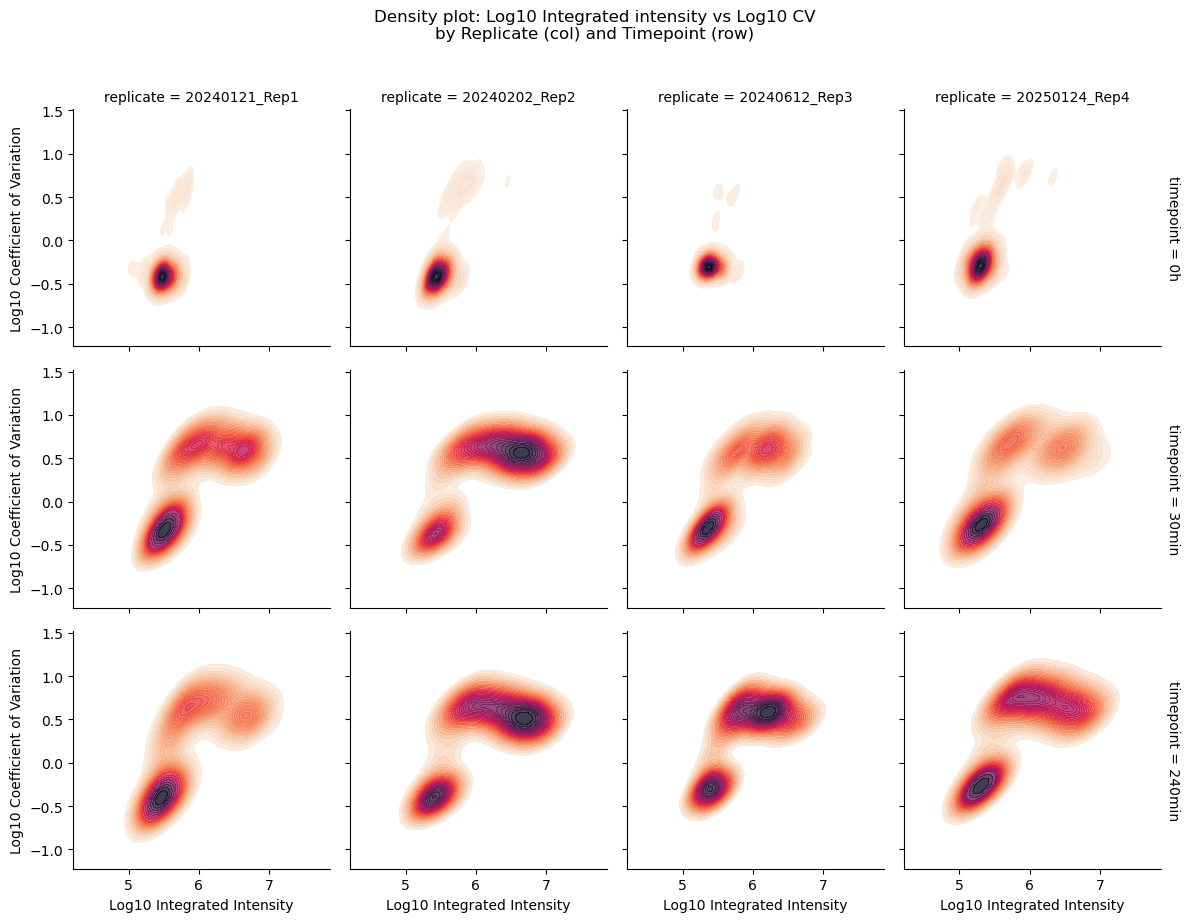

In [22]:
g = sns.FacetGrid(df, row='timepoint', col='replicate', height=3, margin_titles=True,
                  sharex=True, sharey=True)

def kde_scatter(data, color, **kwargs):
    sns.kdeplot(
        data=data,
        x='log10_intensity',
        y='log10_cv_intensity',
        fill=True,
        thresh=0.05,  # avoids painting the full plot area
        levels=30,
        cmap='rocket_r',  # or 'mako', 'Greens'
        alpha=0.8,
        ax=plt.gca()
    )


g.map_dataframe(kde_scatter)

g.set_axis_labels('Log10 Integrated Intensity', 'Log10 Coefficient of Variation')
g.fig.suptitle('Density plot: Log10 Integrated intensity vs Log10 CV\nby Replicate (col) and Timepoint (row)', y=1.02)
plt.tight_layout()
plt.show()

---
## 🧬 Step 4: Cell classification and signal quantification

### 4.1 Determining "on" cells using the coefficient of variation (CV) of nuclear signal

A quick replot of the CV distribution:

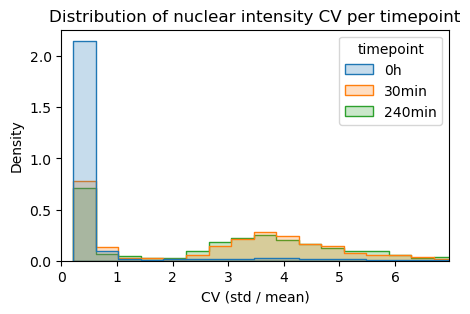

In [23]:
plt.figure(figsize=(5, 3))
sns.histplot(
    data=df,
    x='cv_intensity',
    hue='timepoint',
    element='step',
    stat='density',
    common_norm=False
)
plt.title("Distribution of nuclear intensity CV per timepoint")
plt.xlabel("CV (std / mean)")
plt.ylabel("Density")
plt.xlim(0, np.percentile(df['cv_intensity'], 99))  # zoom in a bit
plt.show()

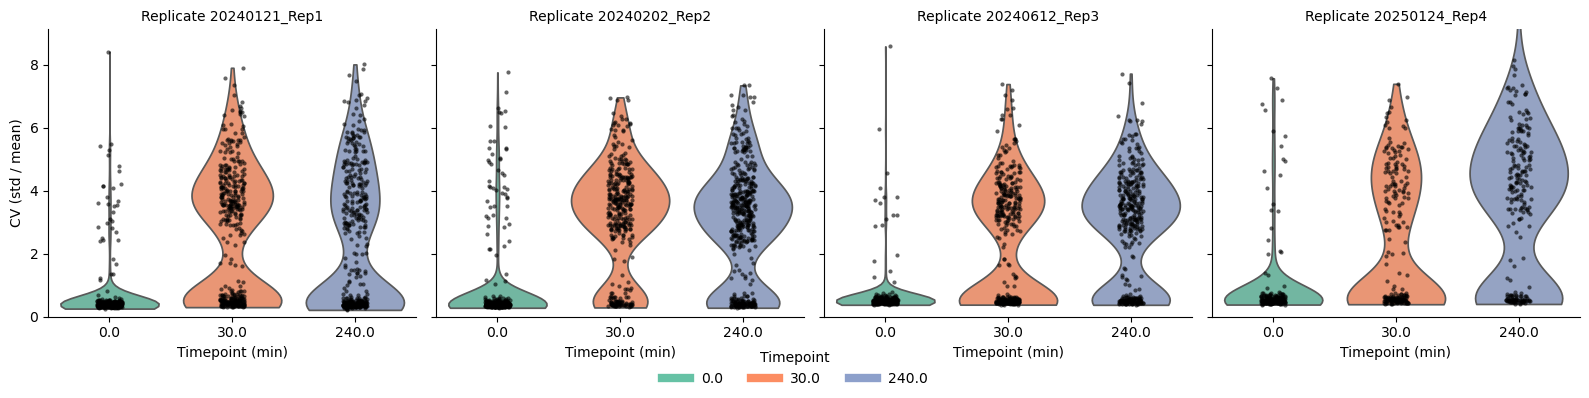

In [24]:
# Convert timepoints to numeric if not already
df['timepoint_numeric'] = (
    df['timepoint']
    .str.replace('h','', regex=False)
    .str.replace('min','', regex=False)
    .astype(float)
)

palette = sns.color_palette("Set2", n_colors=df['timepoint_numeric'].nunique())

g = sns.FacetGrid(
    df,
    col='replicate',
    sharey=True,
    height=4,
    aspect=1
)

# Violin plot
g.map_dataframe(
    sns.violinplot,
    x='timepoint_numeric',
    y='cv_intensity',
    hue='timepoint_numeric',  # NEW: avoid FutureWarning
    palette=palette,
    inner=None,
    #bw_adjust=0.5,
    cut=0,
    dodge=False  # keep violins aligned with x
)

# Overlay points manually without hue/dodge to align correctly
g.map_dataframe(
    sns.stripplot,
    x='timepoint_numeric',
    y='cv_intensity',
    color='k',  # black points for clarity
    size=3,
    alpha=0.6,
    jitter=True
)

# Axis labels and titles
g.set_axis_labels("Timepoint (min)", "CV (std / mean)")
g.set_titles("Replicate {col_name}")
g.set(ylim=(0, np.percentile(df['cv_intensity'], 99.99)))

# Remove any legends on individual axes
for ax in g.axes.flat:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Add a single legend below the grid
handles = [plt.Line2D([0],[0], color=palette[i], lw=6) for i in range(len(palette))]
labels = sorted(df['timepoint_numeric'].unique())
g.fig.legend(handles, labels, title="Timepoint", loc='lower center', ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0,0.05,1,1])  # leave space at bottom for legend
plt.show()


In [25]:
# Keep replicate and cv_intensity
cv_all = df[['replicate', 'cv_intensity']].copy()

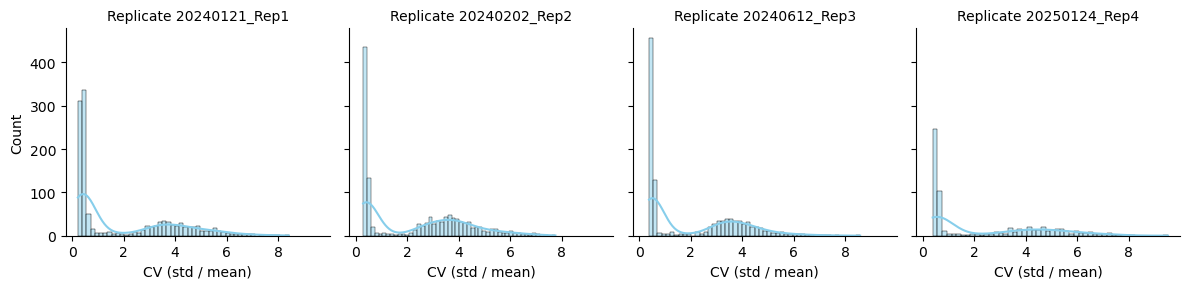

In [26]:
g = sns.FacetGrid(cv_all, col='replicate', sharey=True, height=3, aspect=1)
g.map_dataframe(sns.histplot, x='cv_intensity', bins=50, kde=True, color='skyblue')
g.set_axis_labels("CV (std / mean)", "Count")
g.set_titles("Replicate {col_name}")
plt.tight_layout()
plt.show()


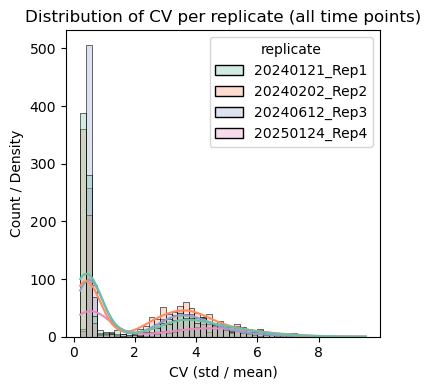

In [27]:
# Single plot with all replicates overlaid
plt.figure(figsize=(4,4))

sns.histplot(
    data=df,
    x='cv_intensity',
    hue='replicate',        # color by replicate
    bins=50,
    kde=True,               # overlay density
    palette='Set2',         # nice distinct colors
    alpha=0.3               # semi-transparent to see overlaps
)

plt.xlabel("CV (std / mean)")
plt.ylabel("Count / Density")
plt.title("Distribution of CV per replicate (all time points)")
plt.tight_layout()
plt.show()


In [28]:
df

cell_id  area_px  intensity_mean  intensity_std  intensity_median  \
0           1   5859.0      104.146441     248.754200              85.0   
1           2   5213.0       71.896796      25.456886              69.0   
2           3   3545.0       79.387870      28.847978              76.0   
3           4   7573.0       78.919451      29.144995              76.0   
4           5   3867.0       78.976726      39.998261              74.0   
...       ...      ...             ...            ...               ...   
4265      225   3595.0      613.244228    2196.643391              90.0   
4266      226   4022.0      149.922178    1061.958279              53.0   
4267      227   4448.0       50.309802      30.046626              46.0   
4268      228   4849.0     1593.825531    5322.143477             146.0   
4269      229   4275.0      410.582924    2171.175206              76.0   

      integrated_intensity      replicate timepoint  log10_intensity  \
0                 610194.0  20240121_Rep1        0h         5.785468   
1                 374798.0  20240121_Rep1        0h         5.573797   
2                 281430.0  20240121_Rep1        0h         5.449370   
3                 597657.0  20240121_Rep1        0h         5.776452   
4                 305403.0  20240121_Rep1        0h         5.484873   
...                    ...            ...       ...              ...   
4265             2204613.0  20250124_Rep4    240min         6.343332   
4266              602987.0  20250124_Rep4    240min         5.780308   
4267              223778.0  20250124_Rep4    240min         5.349817   
4268             7728460.0  20250124_Rep4    240min         6.888093   
4269             1755242.0  20250124_Rep4    240min         6.244337   

      log10_median_intensity  log10_mean_intensity  log10_std_intensity  \
0                   1.929419              2.017644             2.395770   
1                   1.838849              1.856710             1.405805   
2                   1.880814              1.899754             1.460115   
3                   1.880814              1.897184             1.464564   
4                   1.869232              1.897499             1.602041   
...                      ...                   ...                  ...   
4265                1.954243              2.787633             3.341760   
4266                1.724276              2.175866             3.026107   
4267                1.662758              1.701653             1.477796   
4268                2.164353              3.202441             3.726087   
4269                1.880814              2.613401             3.336695   

      cv_intensity  log10_cv_intensity                     time_rep  \
0         2.388504            0.378126      0h min | R20240121_Rep1   
1         0.354075           -0.450904      0h min | R20240121_Rep1   
2         0.363380           -0.439639      0h min | R20240121_Rep1   
3         0.369301           -0.432620      0h min | R20240121_Rep1   
4         0.506456           -0.295458      0h min | R20240121_Rep1   
...            ...                 ...                          ...   
4265      3.582004            0.554126  240min min | R20250124_Rep4   
4266      7.083397            0.850242  240min min | R20250124_Rep4   
4267      0.597232           -0.223857  240min min | R20250124_Rep4   
4268      3.339226            0.523646  240min min | R20250124_Rep4   
4269      5.288031            0.723294  240min min | R20250124_Rep4   

      timepoint_numeric  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
4265              240.0  
4266              240.0  
4267              240.0  
4268              240.0  
4269              240.0  

[4262 rows x 16 columns]

In [29]:
# Filter out any completely unusable replicate if needed (can also be done in the end --> see below)
# bad_reps = ["20240327_Rep1", "20251002_Rep5"]
bad_reps = ["20240000", "20250000"]  # these mock replicates will not filter out anything

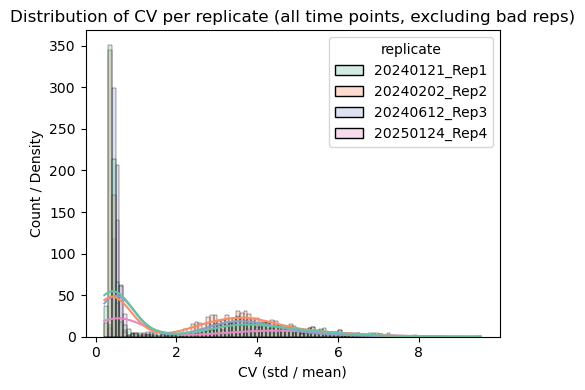

In [30]:
# Filter out bad reps
df_filtered = df[~df['replicate'].isin(bad_reps)].copy()

# Plot overlay histogram with KDE
plt.figure(figsize=(5,4))
sns.histplot(
    data=df_filtered,
    x='cv_intensity',
    hue='replicate',
    bins=100,
    kde=True,
    palette='Set2',
    alpha=0.3
)
plt.xlabel("CV (std / mean)")
plt.ylabel("Count / Density")
plt.title("Distribution of CV per replicate (all time points, excluding bad reps)")
plt.tight_layout()
plt.show()


---
#### Determine cutoff between "on" and "off" cells by fitting a Gaussian Mixture Model (GMM)
For now, we'll exclude the `bad_reps`, but we might use them again for comparison.

In [31]:
df_filtered

cell_id  area_px  intensity_mean  intensity_std  intensity_median  \
0           1   5859.0      104.146441     248.754200              85.0   
1           2   5213.0       71.896796      25.456886              69.0   
2           3   3545.0       79.387870      28.847978              76.0   
3           4   7573.0       78.919451      29.144995              76.0   
4           5   3867.0       78.976726      39.998261              74.0   
...       ...      ...             ...            ...               ...   
4265      225   3595.0      613.244228    2196.643391              90.0   
4266      226   4022.0      149.922178    1061.958279              53.0   
4267      227   4448.0       50.309802      30.046626              46.0   
4268      228   4849.0     1593.825531    5322.143477             146.0   
4269      229   4275.0      410.582924    2171.175206              76.0   

      integrated_intensity      replicate timepoint  log10_intensity  \
0                 610194.0  20240121_Rep1        0h         5.785468   
1                 374798.0  20240121_Rep1        0h         5.573797   
2                 281430.0  20240121_Rep1        0h         5.449370   
3                 597657.0  20240121_Rep1        0h         5.776452   
4                 305403.0  20240121_Rep1        0h         5.484873   
...                    ...            ...       ...              ...   
4265             2204613.0  20250124_Rep4    240min         6.343332   
4266              602987.0  20250124_Rep4    240min         5.780308   
4267              223778.0  20250124_Rep4    240min         5.349817   
4268             7728460.0  20250124_Rep4    240min         6.888093   
4269             1755242.0  20250124_Rep4    240min         6.244337   

      log10_median_intensity  log10_mean_intensity  log10_std_intensity  \
0                   1.929419              2.017644             2.395770   
1                   1.838849              1.856710             1.405805   
2                   1.880814              1.899754             1.460115   
3                   1.880814              1.897184             1.464564   
4                   1.869232              1.897499             1.602041   
...                      ...                   ...                  ...   
4265                1.954243              2.787633             3.341760   
4266                1.724276              2.175866             3.026107   
4267                1.662758              1.701653             1.477796   
4268                2.164353              3.202441             3.726087   
4269                1.880814              2.613401             3.336695   

      cv_intensity  log10_cv_intensity                     time_rep  \
0         2.388504            0.378126      0h min | R20240121_Rep1   
1         0.354075           -0.450904      0h min | R20240121_Rep1   
2         0.363380           -0.439639      0h min | R20240121_Rep1   
3         0.369301           -0.432620      0h min | R20240121_Rep1   
4         0.506456           -0.295458      0h min | R20240121_Rep1   
...            ...                 ...                          ...   
4265      3.582004            0.554126  240min min | R20250124_Rep4   
4266      7.083397            0.850242  240min min | R20250124_Rep4   
4267      0.597232           -0.223857  240min min | R20250124_Rep4   
4268      3.339226            0.523646  240min min | R20250124_Rep4   
4269      5.288031            0.723294  240min min | R20250124_Rep4   

      timepoint_numeric  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
4265              240.0  
4266              240.0  
4267              240.0  
4268              240.0  
4269              240.0  

[4262 rows x 16 columns]

20240121_Rep1: Threshold between 'off' and 'on' cells = 0.642


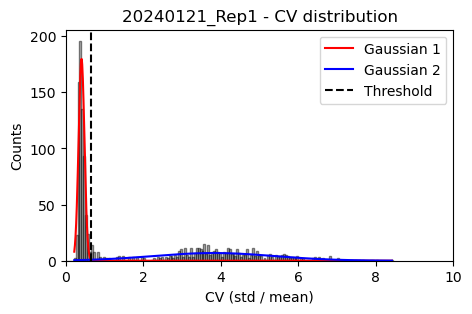

20240202_Rep2: Threshold between 'off' and 'on' cells = 0.605


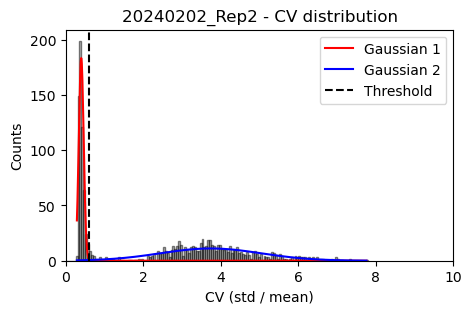

20240612_Rep3: Threshold between 'off' and 'on' cells = 0.722


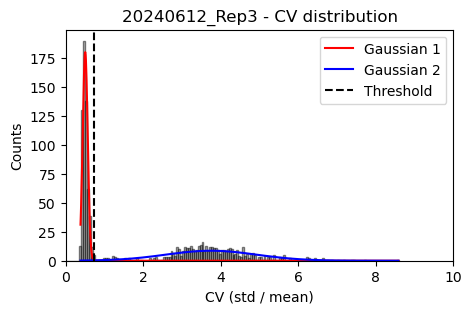

20250124_Rep4: Threshold between 'off' and 'on' cells = 0.833


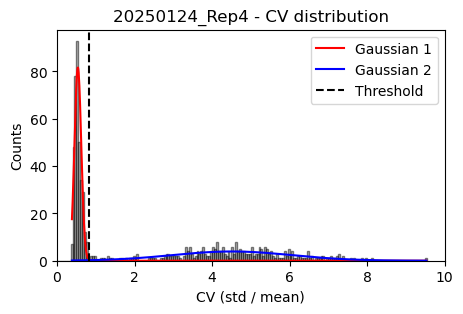

In [32]:
binwidth = 0.05

cv_df = df_filtered[~df_filtered['replicate'].isin(bad_reps)].copy()
reps_to_use = cv_df['replicate'].unique()
thresholds = {}

for rep in reps_to_use:
    df_rep = cv_df[cv_df['replicate'] == rep]
    cv_values = df_rep['cv_intensity'].values.reshape(-1, 1)

    bins = np.arange(0, cv_values.max() + binwidth, binwidth)
    
    # Fit 2-component Gaussian Mixture
    gmm = GaussianMixture(
        n_components=2, 
        random_state=0, 
        n_init=100, 
        means_init=np.array([[0.3],[3.5]]),
        precisions_init=np.array([[[1/0.1**2]], [[1/1.0**2]]])
    )
    gmm.fit(cv_values)

    means = gmm.means_.flatten()
    stds = np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_.flatten()

    # Compute histogram for proper scaling
    counts, bin_edges = np.histogram(cv_values, bins=bins)
    bin_width = bin_edges[1] - bin_edges[0]
    scale_factor = len(cv_values) * bin_width  # scale PDF to histogram counts

    # Find intersection of the two Gaussians
    x = np.linspace(cv_values.min(), cv_values.max(), 1000)
    pdf1 = weights[0] * stats_norm.pdf(x, means[0], stds[0]) * scale_factor
    pdf2 = weights[1] * stats_norm.pdf(x, means[1], stds[1]) * scale_factor
    intersection_idx = np.argwhere(np.diff(np.sign(pdf1 - pdf2))).flatten()
    threshold = x[intersection_idx[0]] if len(intersection_idx) > 0 else np.mean(means)
    thresholds[rep] = threshold

    print(f"{rep}: Threshold between 'off' and 'on' cells = {threshold:.3f}")

    # Plot histogram + PDFs + threshold
    plt.figure(figsize=(5,3))
    plt.hist(cv_values.flatten(), bins=bins, color='gray', alpha=0.5, edgecolor='black')
    plt.plot(x, pdf1, 'r-', label='Gaussian 1')
    plt.plot(x, pdf2, 'b-', label='Gaussian 2')
    plt.axvline(threshold, color='k', linestyle='--', label='Threshold')
    plt.title(f"{rep} - CV distribution")
    plt.xlabel("CV (std / mean)")
    plt.ylabel("Counts")
    plt.xlim(0, 10)  # set x-axis limit
    plt.legend()
    plt.show()


In [33]:
df_filtered

cell_id  area_px  intensity_mean  intensity_std  intensity_median  \
0           1   5859.0      104.146441     248.754200              85.0   
1           2   5213.0       71.896796      25.456886              69.0   
2           3   3545.0       79.387870      28.847978              76.0   
3           4   7573.0       78.919451      29.144995              76.0   
4           5   3867.0       78.976726      39.998261              74.0   
...       ...      ...             ...            ...               ...   
4265      225   3595.0      613.244228    2196.643391              90.0   
4266      226   4022.0      149.922178    1061.958279              53.0   
4267      227   4448.0       50.309802      30.046626              46.0   
4268      228   4849.0     1593.825531    5322.143477             146.0   
4269      229   4275.0      410.582924    2171.175206              76.0   

      integrated_intensity      replicate timepoint  log10_intensity  \
0                 610194.0  20240121_Rep1        0h         5.785468   
1                 374798.0  20240121_Rep1        0h         5.573797   
2                 281430.0  20240121_Rep1        0h         5.449370   
3                 597657.0  20240121_Rep1        0h         5.776452   
4                 305403.0  20240121_Rep1        0h         5.484873   
...                    ...            ...       ...              ...   
4265             2204613.0  20250124_Rep4    240min         6.343332   
4266              602987.0  20250124_Rep4    240min         5.780308   
4267              223778.0  20250124_Rep4    240min         5.349817   
4268             7728460.0  20250124_Rep4    240min         6.888093   
4269             1755242.0  20250124_Rep4    240min         6.244337   

      log10_median_intensity  log10_mean_intensity  log10_std_intensity  \
0                   1.929419              2.017644             2.395770   
1                   1.838849              1.856710             1.405805   
2                   1.880814              1.899754             1.460115   
3                   1.880814              1.897184             1.464564   
4                   1.869232              1.897499             1.602041   
...                      ...                   ...                  ...   
4265                1.954243              2.787633             3.341760   
4266                1.724276              2.175866             3.026107   
4267                1.662758              1.701653             1.477796   
4268                2.164353              3.202441             3.726087   
4269                1.880814              2.613401             3.336695   

      cv_intensity  log10_cv_intensity                     time_rep  \
0         2.388504            0.378126      0h min | R20240121_Rep1   
1         0.354075           -0.450904      0h min | R20240121_Rep1   
2         0.363380           -0.439639      0h min | R20240121_Rep1   
3         0.369301           -0.432620      0h min | R20240121_Rep1   
4         0.506456           -0.295458      0h min | R20240121_Rep1   
...            ...                 ...                          ...   
4265      3.582004            0.554126  240min min | R20250124_Rep4   
4266      7.083397            0.850242  240min min | R20250124_Rep4   
4267      0.597232           -0.223857  240min min | R20250124_Rep4   
4268      3.339226            0.523646  240min min | R20250124_Rep4   
4269      5.288031            0.723294  240min min | R20250124_Rep4   

      timepoint_numeric  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
4265              240.0  
4266              240.0  
4267              240.0  
4268              240.0  
4269              240.0  

[4262 rows x 16 columns]

In [34]:
# Try a direct map first
df_filtered['threshold'] = df_filtered['replicate'].map(thresholds)

## optional
# If mapping failed because of dtype mismatch (e.g. keys are strings but df.replicate are ints),
# try mapping using stringified keys:
if df_filtered['threshold'].isna().any():
    thresholds_str = {str(k): v for k, v in thresholds.items()}
    df_filtered['threshold'] = df_filtered['replicate'].astype(str).map(thresholds_str)
    

# If there are still missing thresholds, handle them (raise)
missing_reps = df_filtered[df_filtered['threshold'].isna()]['replicate'].unique()
if len(missing_reps) > 0:
    for rep in missing_reps:
        n_cells = (df_filtered['replicate'] == rep).sum()
        print(f"Replicate {rep} had {n_cells} cells, GMM threshold missing.")
    raise RuntimeError(f"No threshold found for replicates: {missing_reps}")


# assign state using the per-row threshold
df_filtered['state'] = np.where(df_filtered['cv_intensity'] >= df_filtered['threshold'], 'on', 'off')

# optional: drop helper column
df_filtered = df_filtered.drop(columns=['threshold'])

# Then compute fraction active as before
frac_active_df = (
    df_filtered
    .groupby(['replicate', 'timepoint_numeric'], as_index=False)
    .agg(
        n_total=('state', 'size'),
        n_on=('state', lambda x: (x == 'on').sum())
    )
)
frac_active_df['frac_active'] = frac_active_df['n_on'] / frac_active_df['n_total']

tp_map = {0: "0h", 30: "30min", 240: "240min"}
frac_active_df['timepoint'] = frac_active_df['timepoint_numeric'].map(tp_map)
frac_active_df['timepoint'] = pd.Categorical(
    frac_active_df['timepoint'],
    categories=["0h", "30min", "240min"],
    ordered=True
)

In [35]:
frac_active_df

replicate  timepoint_numeric  n_total  n_on  frac_active timepoint
0   20240121_Rep1                0.0      418    36     0.086124        0h
1   20240121_Rep1               30.0      387   262     0.677003     30min
2   20240121_Rep1              240.0      409   235     0.574572    240min
3   20240202_Rep2                0.0      460    57     0.123913        0h
4   20240202_Rep2               30.0      357   295     0.826331     30min
5   20240202_Rep2              240.0      480   368     0.766667    240min
6   20240612_Rep3                0.0      350    21     0.060000        0h
7   20240612_Rep3               30.0      372   215     0.577957     30min
8   20240612_Rep3              240.0      370   270     0.729730    240min
9   20250124_Rep4                0.0      213    25     0.117371        0h
10  20250124_Rep4               30.0      219   115     0.525114     30min
11  20250124_Rep4              240.0      227   160     0.704846    240min

Since the number of “off” cells can be very low at later time points, we estimate the background per replicate by pooling all nuclei classified as “off” across all time points. For each nucleus, we take the median of its pixel intensities, and then compute the median across all “off” nuclei in the replicate. The **excess signal** is then calculated as the integrated intensity per nucleus minus the background times the nuclear area in pixels.

Let $I_i$ be the integrated intensity of nucleus $i$, $A_i$ its area in pixels, and $B_r$ the background for replicate $r$, calculated as the median of the median of all “off” nuclei in that replicate. Then the **excess signal** for nucleus $i$ is:

$$
\text{Excess}_i = I_i - B_r \cdot A_i
$$

where

$$
B_r = \text{median}\Big(\{ \text{median}(\text{pixel intensities of nucleus } j) \,|\, \text{nucleus } j \text{ is off in replicate } r \}\Big)
$$

This procedure ensures a robust background estimate even for replicates/time points with few “off” cells.


In [36]:
# --- Step 1: Compute background per replicate from "off" cells ---
# B_r = median over nucleus-level median intensities for OFF cells in replicate r

off_cells = df_filtered[df_filtered['state'] == 'off'].copy()

background_per_replicate = (
    off_cells
    .groupby('replicate', as_index=False)['intensity_median']
    .median()
    .rename(columns={'intensity_median': 'background'})
)

# --- Step 2: Merge background into df_filtered ---
df_filtered = df_filtered.merge(background_per_replicate, on='replicate', how='left')

# Optional but recommended: strict check that every replicate has a background
missing_bg = df_filtered[df_filtered['background'].isna()]['replicate'].unique()
if len(missing_bg) > 0:
    raise RuntimeError(f"No background found for replicates (no OFF cells?): {missing_bg}")

# --- Step 3: Compute excess signal ---
df_filtered['excess_signal'] = (
    df_filtered['integrated_intensity']
    - df_filtered['background'] * df_filtered['area_px']
)


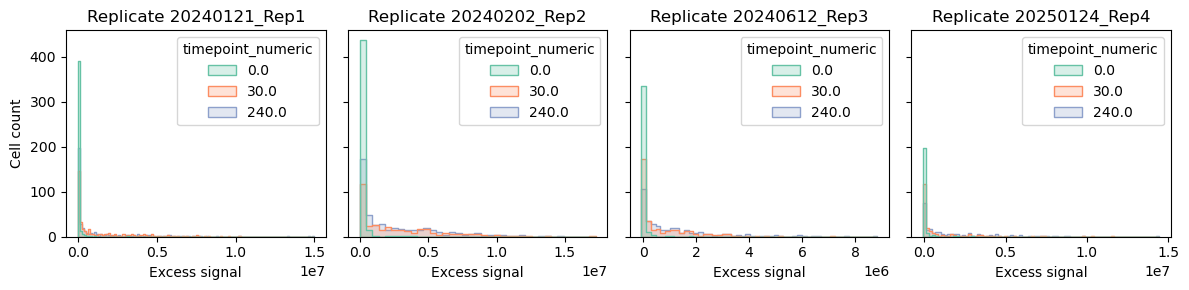

In [37]:
# --- Step 4: Histograms of excess signal with consistent binwidth and counts ---
#binwidth = 10  # adjust to your preferred resolution
fig, axes = plt.subplots(1, 4, figsize=(12,3), sharey=True)

for i, rep in enumerate(sorted(df_filtered['replicate'].unique())):
    sns.histplot(
        data=df_filtered[df_filtered['replicate']==rep],
        x='excess_signal',
        hue='timepoint_numeric',
        element='step',
        stat='count',      # count instead of density
        #binwidth=binwidth, # fixed bin width
        palette='Set2',
        ax=axes[i]
    )
    axes[i].set_title(f"Replicate {rep}")
    axes[i].set_xlabel("Excess signal")
    axes[i].set_ylabel("Cell count")

plt.tight_layout()
plt.show()

/Users/anne/micromamba/envs/microscopy-env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


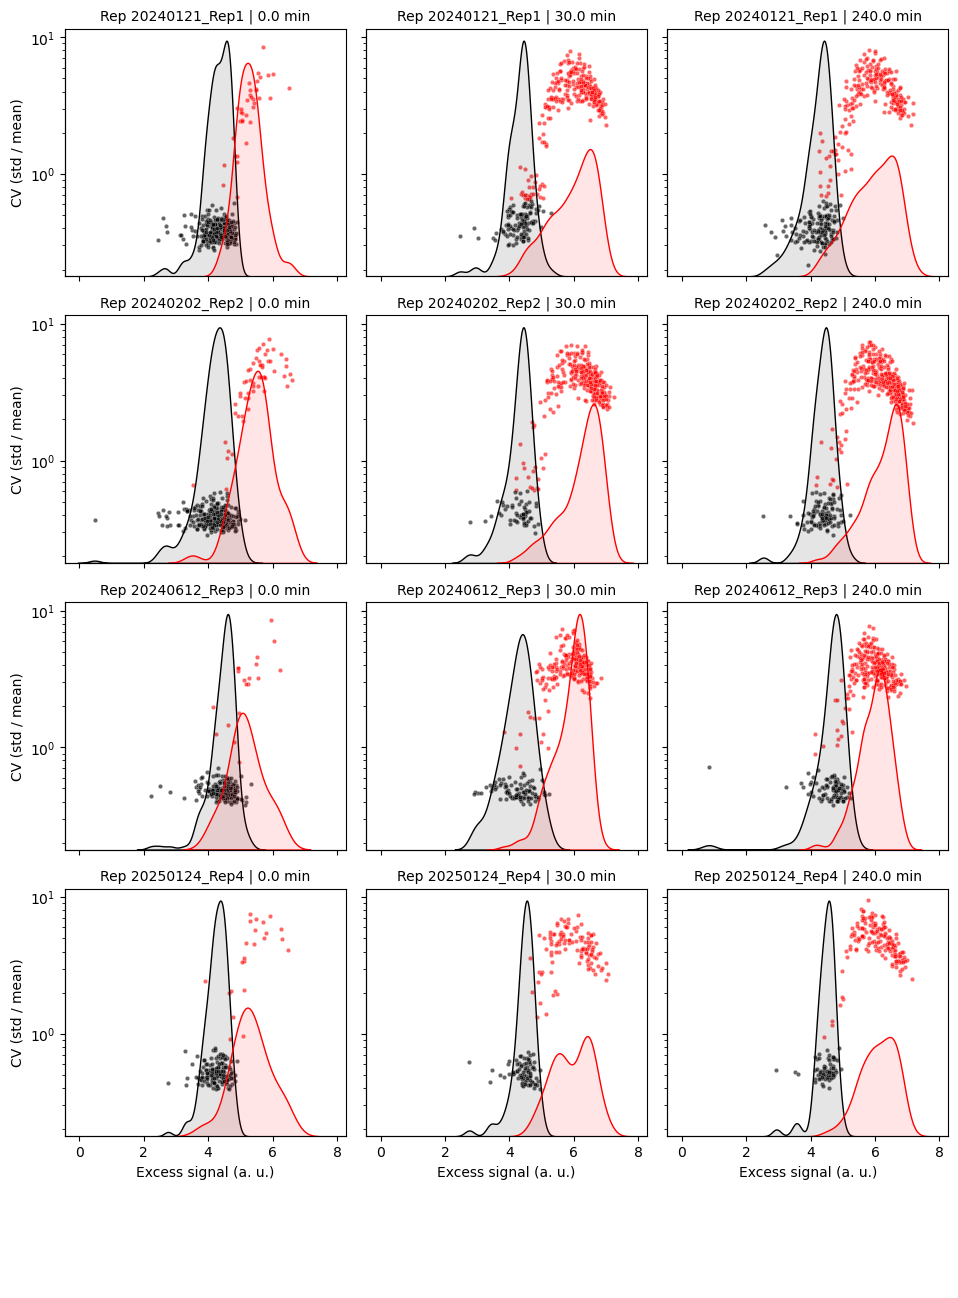

In [38]:
# Log-transform excess_signal for KDE plotting
df_filtered = df_filtered.copy()
df_filtered['log10_excess_signal'] = np.log10(df_filtered['excess_signal'])

# Define color mapping
state_palette = {"off": "black", "on": "red"}

# Ensure timepoint_numeric exists
if "timepoint_numeric" not in df_filtered.columns:
    df_filtered["timepoint_numeric"] = (
        df_filtered["timepoint"]
        .str.replace("h", "", regex=False)
        .str.replace("min", "", regex=False)
        .astype(float)
    )

# Create FacetGrid
g = sns.FacetGrid(
    df_filtered,
    row="replicate",
    col="timepoint_numeric",
    hue="state",
    palette=state_palette,
    sharex=True,
    sharey=True,
    height=3,
    aspect=1
)

# Scatter plot
g.map_dataframe(
    sns.scatterplot,
    x="log10_excess_signal",
    y="cv_intensity",
    alpha=0.6,
    s=10
)

# Add marginal KDE for log10_excess_signal per facet
for ax, (rep, tp) in zip(g.axes.flat, 
                          [(r, t) for r in sorted(df_filtered['replicate'].unique())
                                   for t in sorted(df_filtered['timepoint_numeric'].unique())]):
    subset = df_filtered[(df_filtered['replicate'] == rep) & 
                            (df_filtered['timepoint_numeric'] == tp)]
    
    # Create a twin axis for top KDE
    ax_top = ax.twinx()
    ax_top.set_yticks([])  # hide ticks
    ax_top.grid(False)      # hide grid
    for state, color in state_palette.items():
        data = subset[subset['state'] == state]['log10_excess_signal']
        if len(data) > 1:
            sns.kdeplot(
                data=data,
                ax=ax_top,
                color=color,
                fill=True,
                alpha=0.1,
                common_norm=False
            )
    ax_top.set_ylabel('')  # hide label

# Labels, titles, scales
g.set_axis_labels("Excess signal (a. u.)", "CV (std / mean)")
g.set_titles("Rep {row_name} | {col_name} min")
g.add_legend(title="State")
g._legend.set_bbox_to_anchor((0.5, -0.05))
g._legend.set_loc("center")
g.set(yscale="log")

plt.tight_layout()
plt.show()


In [39]:
# --- 1. Fraction active (all nuclei) ---
frac_active_summary = (
    df_filtered
    .groupby(['replicate', 'timepoint_numeric'], as_index=False)
    .agg(
        n_total_cells=('state', 'size'),
        n_active_cells=('state', lambda x: (x == 'on').sum())
    )
)
frac_active_summary['fraction_active'] = (
    frac_active_summary['n_active_cells'] / frac_active_summary['n_total_cells']
)

# Map numeric to categorical labels
tp_map = {0: "0h", 30: "30min", 240: "240min"}
frac_active_summary['timepoint'] = frac_active_summary['timepoint_numeric'].map(tp_map)
frac_active_summary['timepoint'] = pd.Categorical(
    frac_active_summary['timepoint'],
    categories=["0h", "30min", "240min"],
    ordered=True
)
# Fold change / log2 fold change
frac_active_summary = normalize_to_baseline(frac_active_summary, 'fraction_active')

# --- 2. Median excess signal (only 'on' nuclei) ---
burst_median = (
    df_filtered[df_filtered['state'] == 'on']
    .groupby(['replicate', 'timepoint_numeric'], as_index=False)['excess_signal']
    .median()
    .rename(columns={'excess_signal': 'median_excess_signal'})
)
burst_median['timepoint'] = burst_median['timepoint_numeric'].map(tp_map)
burst_median['timepoint'] = pd.Categorical(
    burst_median['timepoint'],
    categories=["0h", "30min", "240min"],
    ordered=True
)
burst_median = normalize_to_baseline(burst_median, 'median_excess_signal')

# --- 3. Mean excess signal (only 'on' nuclei) ---
burst_mean = (
    df_filtered[df_filtered['state'] == 'on']
    .groupby(['replicate', 'timepoint_numeric'], as_index=False)['excess_signal']
    .mean()
    .rename(columns={'excess_signal': 'mean_excess_signal'})
)
burst_mean['timepoint'] = burst_mean['timepoint_numeric'].map(tp_map)
burst_mean['timepoint'] = pd.Categorical(
    burst_mean['timepoint'],
    categories=["0h", "30min", "240min"],
    ordered=True
)
burst_mean = normalize_to_baseline(burst_mean, 'mean_excess_signal')

# --- 4. Merge into single output_df ---
output_nuc_df = (
    frac_active_summary
    .merge(burst_median, on=['replicate', 'timepoint'], how='outer')
    .merge(burst_mean, on=['replicate', 'timepoint'], how='outer')
)

# --- 5. Select / reorder columns for clarity ---
output_nuc_df = output_nuc_df[[
    'replicate', 'timepoint',
    'n_total_cells', 'n_active_cells',
    'fraction_active', 'fraction_active_fc', 'fraction_active_log2fc',
    #'median_excess_signal', 'median_excess_signal_fc', 'median_excess_signal_log2fc',
    'mean_excess_signal', 'mean_excess_signal_fc', 'mean_excess_signal_log2fc'
]]

# Inspect final table
print(output_nuc_df.head())

       replicate timepoint  n_total_cells  n_active_cells  fraction_active  \
0  20240121_Rep1        0h            418              36         0.086124   
1  20240121_Rep1     30min            387             262         0.677003   
2  20240121_Rep1    240min            409             235         0.574572   
3  20240202_Rep2        0h            460              57         0.123913   
4  20240202_Rep2     30min            357             295         0.826331   

   fraction_active_fc  fraction_active_log2fc  mean_excess_signal  \
0            1.000000                0.000000        3.256307e+05   
1            7.860752                2.974667        2.147349e+06   
2            6.671421                2.737994        2.174346e+06   
3            1.000000                0.000000        6.282074e+05   
4            6.668632                2.737391        3.338100e+06   

   mean_excess_signal_fc  mean_excess_signal_log2fc  
0               1.000000                   0.000000  
1       

In [40]:
maxfoldchange=32
maxlog2fc=5

/var/folders/xv/tc5qt7_s655ct5nb__w4xhrm0000gn/T/ipykernel_57459/2488784959.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  output_nuc_df.groupby('timepoint')
/var/folders/xv/tc5qt7_s655ct5nb__w4xhrm0000gn/T/ipykernel_57459/2488784959.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  output_nuc_df.groupby('timepoint')


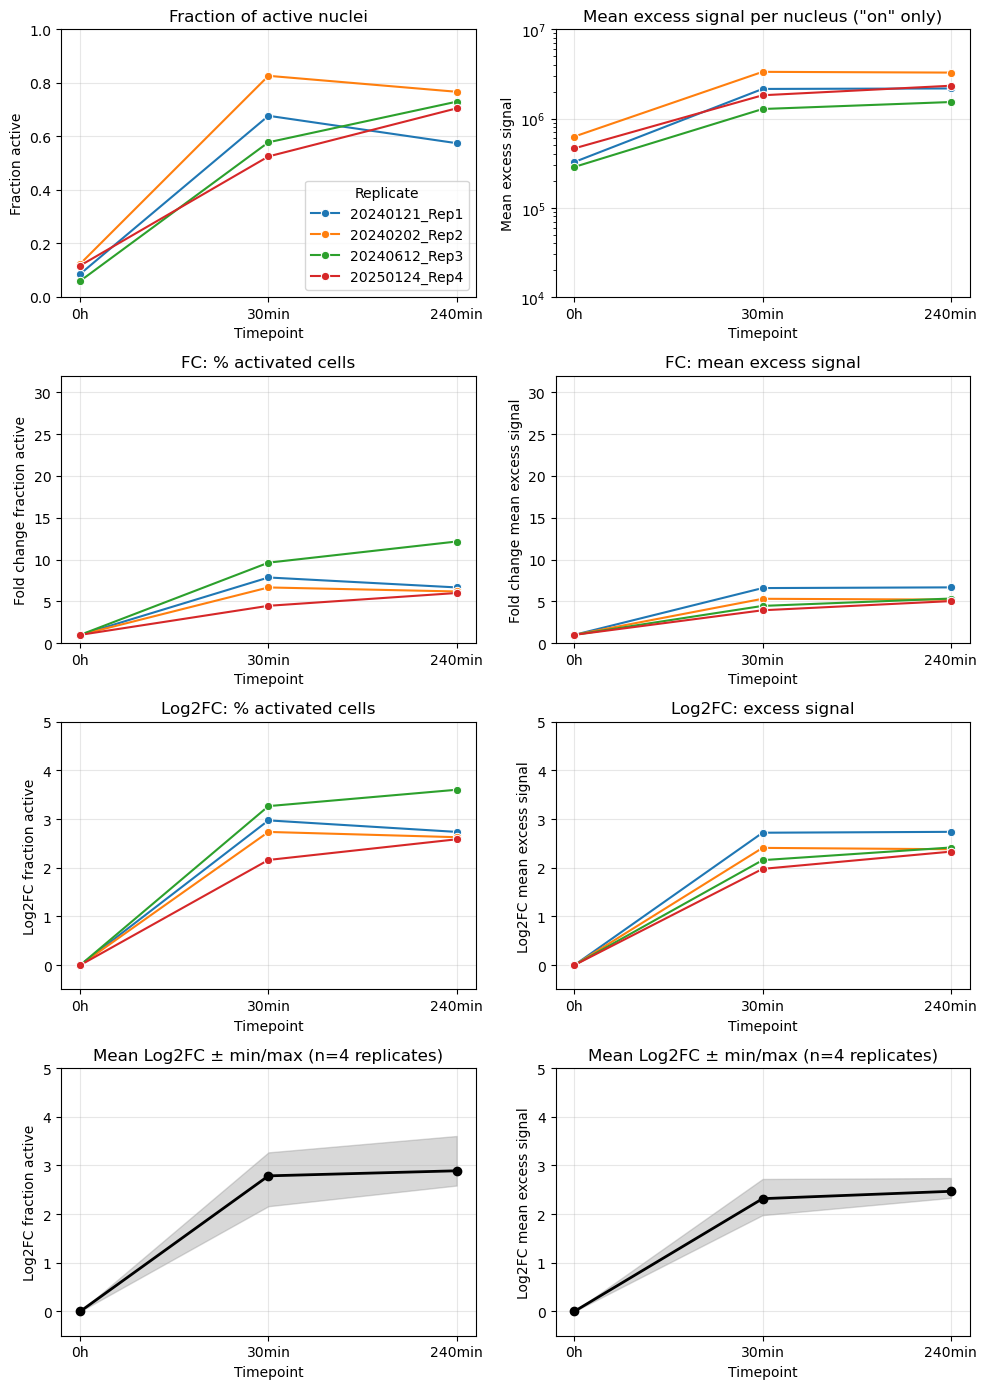

In [41]:
# --- 1. Compute mean ± min/max summaries for row 4 ---
# Fraction active
frac_summary = (
    output_nuc_df.groupby('timepoint')
    ['fraction_active_log2fc']
    .agg(['mean', 'min', 'max'])
    .reset_index()
)
# Mean excess signal
excess_summary = (
    output_nuc_df.groupby('timepoint')
    ['mean_excess_signal_log2fc']
    .agg(['mean', 'min', 'max'])
    .reset_index()
)

n_replicates = output_nuc_df['replicate'].nunique()

# --- 2. Create 4x2 grid ---
fig, axes = plt.subplots(4, 2, figsize=(10, 14), sharey=False)

# ---------------- Row 1: Raw values ----------------
sns.lineplot(data=output_nuc_df, x='timepoint', y='fraction_active',
             hue='replicate', marker='o', ax=axes[0, 0])
axes[0, 0].set_ylabel('Fraction active')
axes[0, 0].set_title('Fraction of active nuclei')
axes[0, 0].set_ylim(0, 1)

sns.lineplot(data=output_nuc_df, x='timepoint', y='mean_excess_signal',
             hue='replicate', marker='o', ax=axes[0, 1])
axes[0, 1].set_ylabel('Mean excess signal')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Mean excess signal per nucleus ("on" only)')
axes[0, 1].set_ylim(10000, 10000000)

# ---------------- Row 2: Fold change ----------------
sns.lineplot(data=output_nuc_df, x='timepoint', y='fraction_active_fc',
             hue='replicate', marker='o', ax=axes[1, 0])
axes[1, 0].set_ylabel('Fold change fraction active')
axes[1, 0].set_ylim(0, maxfoldchange)
axes[1, 0].set_title('FC: % activated cells')

sns.lineplot(data=output_nuc_df, x='timepoint', y='mean_excess_signal_fc',
             hue='replicate', marker='o', ax=axes[1, 1])
axes[1, 1].set_ylabel('Fold change mean excess signal')
axes[1, 1].set_ylim(0, maxfoldchange)
axes[1, 1].set_title('FC: mean excess signal')

# ---------------- Row 3: Log2FC ----------------
sns.lineplot(data=output_nuc_df, x='timepoint', y='fraction_active_log2fc',
             hue='replicate', marker='o', ax=axes[2, 0])
axes[2, 0].set_ylabel('Log2FC fraction active')
axes[2, 0].set_ylim(-0.5, maxlog2fc)
axes[2, 0].set_title('Log2FC: % activated cells')

sns.lineplot(data=output_nuc_df, x='timepoint', y='mean_excess_signal_log2fc',
             hue='replicate', marker='o', ax=axes[2, 1])
axes[2, 1].set_ylabel('Log2FC mean excess signal')
axes[2, 1].set_title('Log2FC: excess signal')
axes[2, 1].set_ylim(-0.5, maxlog2fc)

# ---------------- Row 4: Log2FC mean ± min/max ----------------
axes[3, 0].plot(frac_summary['timepoint'], frac_summary['mean'],
                marker='o', color='black', linewidth=2)
axes[3, 0].fill_between(frac_summary['timepoint'], frac_summary['min'], frac_summary['max'],
                        color='gray', alpha=0.3)
axes[3, 0].set_ylabel('Log2FC fraction active')
axes[3, 0].set_title(f'Mean Log2FC ± min/max (n={n_replicates} replicates)')

axes[3, 1].plot(excess_summary['timepoint'], excess_summary['mean'],
                marker='o', color='black', linewidth=2)
axes[3, 1].fill_between(excess_summary['timepoint'], excess_summary['min'], excess_summary['max'],
                        color='gray', alpha=0.3)
axes[3, 1].set_ylabel('Log2FC mean excess signal')
axes[3, 1].set_title(f'Mean Log2FC ± min/max (n={n_replicates} replicates)')

# ---------------- General formatting ----------------
# Set y-limits for row 2 (fold-change) 
for ax in axes[1, :]: 
    ax.set_ylim(0, maxfoldchange) 
    
# Set y-limits for rows 3 and 4 (log2FC) 
for row in [2, 3]: 
    for ax in axes[row, :]: 
        ax.set_ylim(-0.5, maxlog2fc)

for i in range(4):
    for j in range(2):
        axes[i, j].set_xlabel('Timepoint')
        axes[i, j].grid(True, alpha=0.3)

# Keep only top-left legend
axes[0, 0].legend(title='Replicate')
axes[0, 1].legend([], [], frameon=False)
axes[1, 0].legend([], [], frameon=False)
axes[1, 1].legend([], [], frameon=False)
axes[2, 0].legend([], [], frameon=False)
axes[2, 1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()


In [42]:

# --- Save to CSV ---
output_nuc_df.to_csv("nucleus_based_summary_CXCL8.csv", index=False)


### 🧹 Filter Out Bad Replicates and Create Final Output

Before generating the final dataset, sometimes certain replicates should be excluded due to technical or experimental issues. These reasons might include:

- excessive dirt/background → leads to **arbitrarily high fraction of active cells** in the unstimulated sample.  
- same biological sample, imaged with different imaging parameters  
   → not true biological replicates → remove **except for one**.  
- different amounts of padlock probes.


/var/folders/xv/tc5qt7_s655ct5nb__w4xhrm0000gn/T/ipykernel_57459/3118034632.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  output_nuc_df_clean.groupby('timepoint')['fraction_active_log2fc']
/var/folders/xv/tc5qt7_s655ct5nb__w4xhrm0000gn/T/ipykernel_57459/3118034632.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  output_nuc_df_clean.groupby('timepoint')['mean_excess_signal_log2fc']


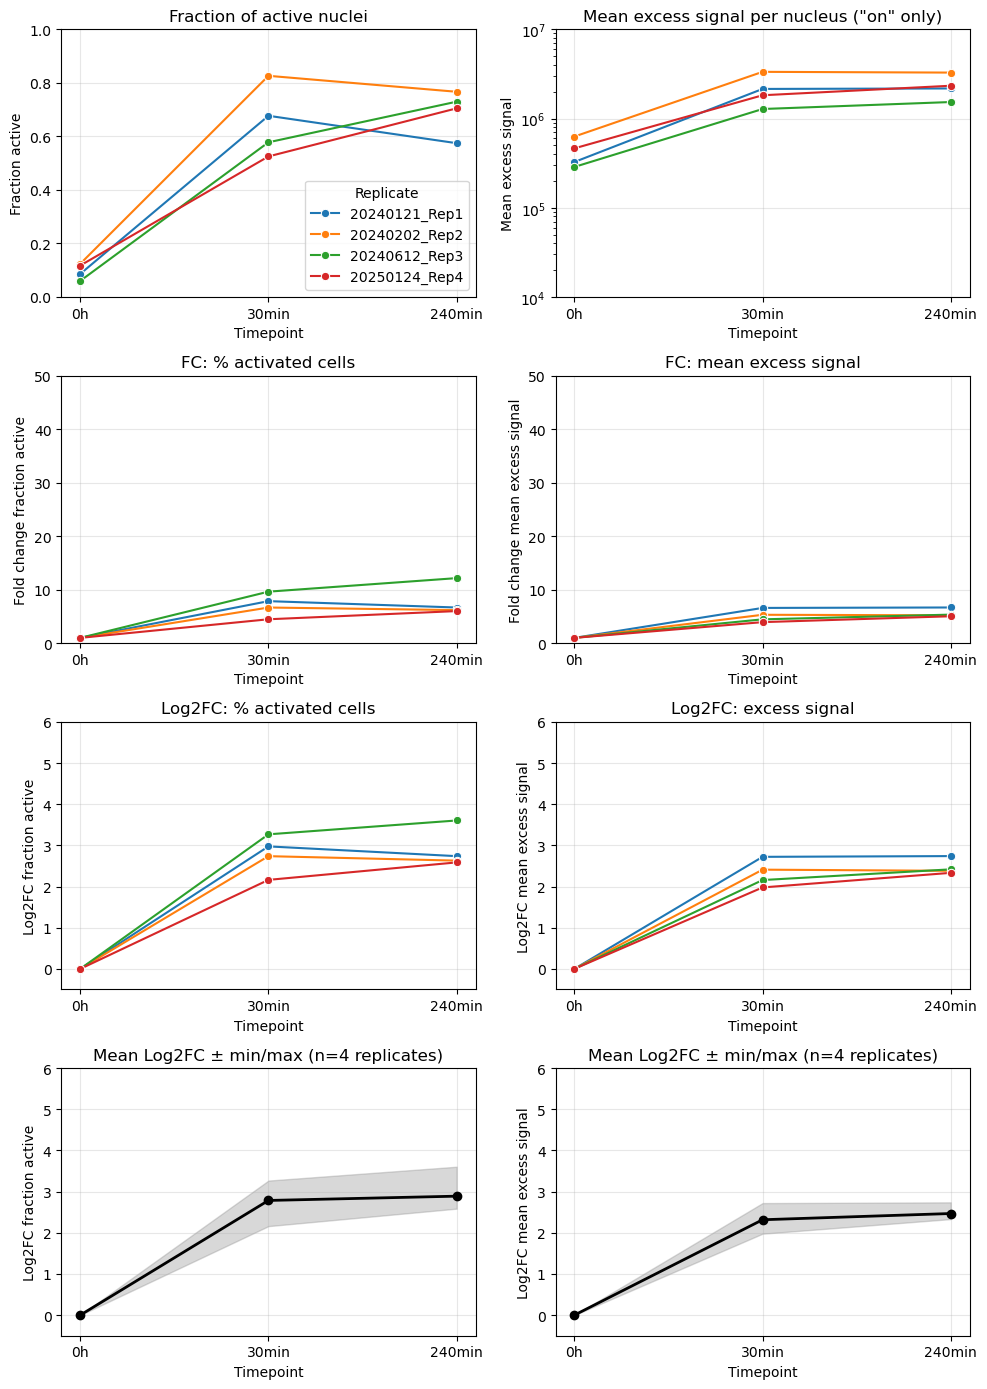

In [43]:
maxfoldchange = 50
maxlog2fc = 6

# ============================================================
# Filter out bad or unmatching replicates before final plotting
# ============================================================

bad_reps = ["20240000", "20250000"]  #dummy IDs --> nothing filtered
output_nuc_df_clean = output_nuc_df[~output_nuc_df['replicate'].isin(bad_reps)].copy()

# ============================================================
# Compute mean ± min/max summaries (Row 4)
# ============================================================

# Fraction active
frac_summary = (
    output_nuc_df_clean.groupby('timepoint')['fraction_active_log2fc']
    .agg(['mean', 'min', 'max'])
    .reset_index()
)

# Mean excess signal
excess_summary = (
    output_nuc_df_clean.groupby('timepoint')['mean_excess_signal_log2fc']
    .agg(['mean', 'min', 'max'])
    .reset_index()
)

n_replicates = output_nuc_df_clean['replicate'].nunique()

# ============================================================
# Create 4×2 grid of plots
# ============================================================

fig, axes = plt.subplots(4, 2, figsize=(10, 14), sharey=False)

# ---------------- Row 1: Raw values ----------------
sns.lineplot(data=output_nuc_df_clean, x='timepoint', y='fraction_active',
             hue='replicate', marker='o', ax=axes[0, 0])
axes[0, 0].set_ylabel('Fraction active')
axes[0, 0].set_title('Fraction of active nuclei')
axes[0, 0].set_ylim(0, 1)

sns.lineplot(data=output_nuc_df_clean, x='timepoint', y='mean_excess_signal',
             hue='replicate', marker='o', ax=axes[0, 1])
axes[0, 1].set_ylabel('Mean excess signal')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Mean excess signal per nucleus ("on" only)')
axes[0, 1].set_ylim(1e4, 1e7)

# ---------------- Row 2: Fold change ----------------
sns.lineplot(data=output_nuc_df_clean, x='timepoint', y='fraction_active_fc',
             hue='replicate', marker='o', ax=axes[1, 0])
axes[1, 0].set_ylabel('Fold change fraction active')
axes[1, 0].set_ylim(0, maxfoldchange)
axes[1, 0].set_title('FC: % activated cells')

sns.lineplot(data=output_nuc_df_clean, x='timepoint', y='mean_excess_signal_fc',
             hue='replicate', marker='o', ax=axes[1, 1])
axes[1, 1].set_ylabel('Fold change mean excess signal')
axes[1, 1].set_ylim(0, maxfoldchange)
axes[1, 1].set_title('FC: mean excess signal')

# ---------------- Row 3: Log2FC ----------------
sns.lineplot(data=output_nuc_df_clean, x='timepoint', y='fraction_active_log2fc',
             hue='replicate', marker='o', ax=axes[2, 0])
axes[2, 0].set_ylabel('Log2FC fraction active')
axes[2, 0].set_ylim(-0.5, maxlog2fc)
axes[2, 0].set_title('Log2FC: % activated cells')

sns.lineplot(data=output_nuc_df_clean, x='timepoint', y='mean_excess_signal_log2fc',
             hue='replicate', marker='o', ax=axes[2, 1])
axes[2, 1].set_ylabel('Log2FC mean excess signal')
axes[2, 1].set_title('Log2FC: excess signal')
axes[2, 1].set_ylim(-0.5, maxlog2fc)

# ---------------- Row 4: Log2FC mean ± min/max ----------------
axes[3, 0].plot(frac_summary['timepoint'], frac_summary['mean'],
                marker='o', color='black', linewidth=2)
axes[3, 0].fill_between(frac_summary['timepoint'], frac_summary['min'], frac_summary['max'],
                        color='gray', alpha=0.3)
axes[3, 0].set_ylabel('Log2FC fraction active')
axes[3, 0].set_title(f'Mean Log2FC ± min/max (n={n_replicates} replicates)')

axes[3, 1].plot(excess_summary['timepoint'], excess_summary['mean'],
                marker='o', color='black', linewidth=2)
axes[3, 1].fill_between(excess_summary['timepoint'], excess_summary['min'], excess_summary['max'],
                        color='gray', alpha=0.3)
axes[3, 1].set_ylabel('Log2FC mean excess signal')
axes[3, 1].set_title(f'Mean Log2FC ± min/max (n={n_replicates} replicates)')

# ============================================================
# Formatting
# ============================================================

# Set consistent limits
for ax in axes[1, :]:
    ax.set_ylim(0, maxfoldchange)
for row in [2, 3]:
    for ax in axes[row, :]:
        ax.set_ylim(-0.5, maxlog2fc)

# Axis labels + grid
for i in range(4):
    for j in range(2):
        axes[i, j].set_xlabel('Timepoint')
        axes[i, j].grid(True, alpha=0.3)

# Keep only top-left legend
axes[0, 0].legend(title='Replicate')
for i in range(4):
    for j in range(2):
        if not (i == 0 and j == 0):
            axes[i, j].legend([], [], frameon=False)

plt.tight_layout()
plt.show()


In [44]:

# --- Save to CSV ---
output_nuc_df_clean.to_csv("nucleus_based_summary_CXCL8.csv", index=False)


---

<font color="grey">Anne Rademacher <br>
Division of Chromatin Networks, DKFZ <br>
December 3, 2025 <br></font>

---